<a href="https://colab.research.google.com/github/auri222/MSC_example/blob/master/music_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Import thư viện cần thiết**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
from collections import Counter

# **2. Đọc dữ liệu**

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/auri222/MSC_example/master/train.csv')
df

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,Green-House,Find Home,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.993000,0.824000,0.0984,0.1770,171.587,193450.0,3,6
17992,Micatone,All Gone,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,257067.0,4,2
17993,Smash Hit Combo,Peine perdue,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,216222.0,4,8
17994,Beherit,Salomon's Gate,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,219693.0,4,8


In [3]:
len(df)

17996

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


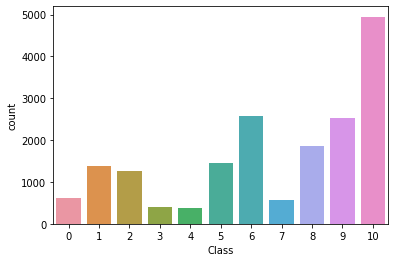

In [4]:
sns.countplot(df['Class'])

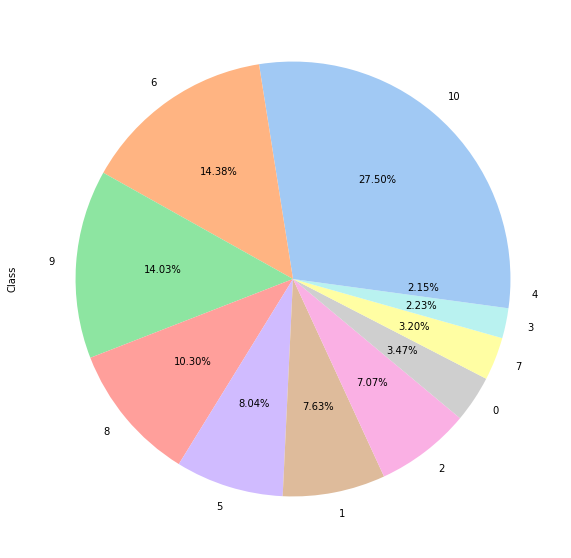

In [64]:
colors = sns.color_palette('pastel')[0:11]
df['Class'].value_counts().plot.pie(colors=colors,autopct='%1.2f%%', figsize=(12,10))

In [6]:
df['Class'].value_counts()

10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: Class, dtype: int64

In [7]:
df.isnull().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

# **3. Điền giá trị null cho cột key, Popularity và instrumentalness bằng giá trị mean của chúng**

In [8]:
#Dữ liệu cột key gồm:
df['key'].value_counts()

7.0     2097
2.0     1994
9.0     1961
1.0     1680
4.0     1549
11.0    1476
5.0     1397
6.0     1190
8.0     1119
10.0    1010
3.0      509
Name: key, dtype: int64

In [9]:
#Giá trị mean của cột key
key_mean = df['key'].mean()
key_mean

5.952446502315104

In [10]:
#Do 5.95 xấp xỉ 6.0 nên làm tròn lên 6.0 và để phù hợp với dữ liệu trường key
key_mean = np.ceil(key_mean)
key_mean

6.0

In [11]:
df['key'] = df['key'].fillna(key_mean)

In [12]:
#Giá trị mean của cột Popularity
popularity_mean = df['Popularity'].mean()
popularity_mean

44.51212431693989

In [13]:
popularity_mean = np.ceil(popularity_mean)
popularity_mean

45.0

In [14]:
#Điền giá trị mean cho cột Popularity
df['Popularity'] = df['Popularity'].fillna(popularity_mean)

In [15]:
#Giá trị mean của cột instrumentalness
instrumentalness_mean = df['instrumentalness'].mean()
instrumentalness_mean

0.1775619253660321

In [16]:
#Điền giá trị mean cho cột instrumentalness
df['instrumentalness'] = df['instrumentalness'].fillna(instrumentalness_mean)

In [17]:
df.isnull().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

# **4. Xóa các cột không dùng để huấn luyện mô hình**

In [18]:
df_new = df.drop(['Artist Name', 'Track Name'], axis=1)
df_new.head(2)

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.0171,0.177562,0.0849,0.899,134.071,234596.0,4,5
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.0011,0.004010,0.1010,0.569,116.454,251733.0,4,10


In [19]:
X_new = df_new.drop(['Class'], axis=1)
X_new.head(2)

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.0171,0.177562,0.0849,0.899,134.071,234596.0,4
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.0011,0.004010,0.1010,0.569,116.454,251733.0,4


In [20]:
y_new = df_new['Class']

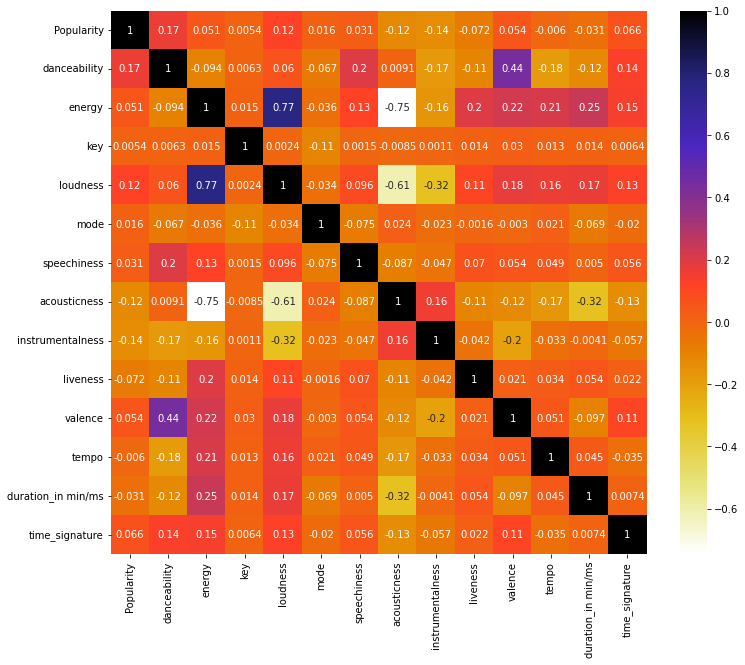

In [21]:
#Biểu đồ tương quan
plt.figure(figsize=(12,10))
corr = X_new.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [22]:
#Từ biểu đồ trên ta có thể thấy là cột loudness và energy có tương quan với nhau => có thể thay thế cột loudness = energy
# Cùng lúc ta có cột acousticness và cột energy cũng có độ tương quan (nghịch) => có thể thay thế cột acousticness = energy

In [23]:
df_new = df_new.drop(['loudness','acousticness'], axis=1)
df_new.head(2)

,Popularity,danceability,energy,key,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,60.0,0.854,0.564,1.0,1,0.0485,0.177562,0.0849,0.899,134.071,234596.0,4,5
1,54.0,0.382,0.814,3.0,1,0.0406,0.004010,0.1010,0.569,116.454,251733.0,4,10


### **Chọn thuộc tính để huấn luyện**

In [24]:
#Bỏ cột liveness, time_signature, mode, key
X_8 = df_new.drop(['key','mode','liveness','time_signature','Class'], axis=1)
X_8.head(2)

,Popularity,danceability,energy,speechiness,instrumentalness,valence,tempo,duration_in min/ms
0,60.0,0.854,0.564,0.0485,0.177562,0.899,134.071,234596.0
1,54.0,0.382,0.814,0.0406,0.004010,0.569,116.454,251733.0


In [25]:
y = df_new['Class']
y.head(2)

0     5
1    10
Name: Class, dtype: int64

In [26]:
#Thuộc tính cũ chỉ chọn Popularity, danceability, energy, speechiness, instrumentalness, duration_in
X_6 = df_new.drop(['key','mode','liveness','time_signature', 'valence','tempo','Class'], axis=1)
X_6.head(2)

,Popularity,danceability,energy,speechiness,instrumentalness,duration_in min/ms
0,60.0,0.854,0.564,0.0485,0.177562,234596.0
1,54.0,0.382,0.814,0.0406,0.004010,251733.0


# **5. Cân bằng dữ liệu bằng cách sử dụng phương pháp OverSampling bằng thư viện imblearn SMOTE**

In [27]:
#Sử dụng SMOTE để tăng lớp thiểu số
from imblearn.over_sampling import SMOTE

In [28]:
sm = SMOTE(sampling_strategy='not majority')

In [29]:
X_sm_8, y_sm_8 = sm.fit_resample(X_8, y)
Counter(y_sm_8)

Counter({0: 4949,
         1: 4949,
         2: 4949,
         3: 4949,
         4: 4949,
         5: 4949,
         6: 4949,
         7: 4949,
         8: 4949,
         9: 4949,
         10: 4949})

In [30]:
X_sm_6, y_sm_6 = sm.fit_resample(X_6, y)
#Counter(y_sm_6)

In [31]:
Counter(y)

Counter({0: 625,
         1: 1373,
         2: 1272,
         3: 402,
         4: 387,
         5: 1447,
         6: 2587,
         7: 576,
         8: 1854,
         9: 2524,
         10: 4949})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


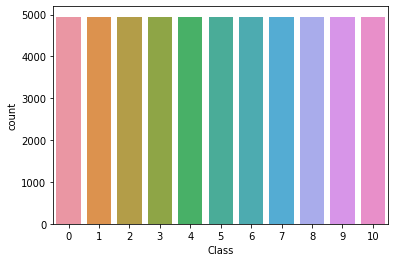

In [32]:
sns.countplot(y_sm_8)

# **6. Huấn luyện mô hình (X_8, X_6)**

In [33]:
#Khởi tạo: Sử dụng thư viện sklearn Gaussian Naive Bayes và Decision tree 
nb = GaussianNB()
dct = DecisionTreeClassifier(criterion="gini",max_depth=7,min_samples_leaf=5)

## **Sử dụng nghi thức đánh giá StratifiedKFold**


*   StratifiedKFold là một biến thể KFold, cũng chia dữ liệu thành các phần (fold) rồi sử dụng 1 phần để kiểm tra và các phần còn lại để huấn luyện mô hình




In [34]:
from sklearn.model_selection import StratifiedKFold

In [35]:
#Khởi tạo thông số cho StratifiedKFold
skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)

### **a. Xây dựng hàm phân loại với StratifiedKFold**

In [36]:
#Hàm sử dụng cho nghi thức StratifiedKFold cho 6 thuộc tính
def classification_StratifiedKFold_6_features(clf1, clf2,X, y, popularity=0, danceability=0, energy=0,speechiness=0, instrumentalness=0, duration=0):
    i=1
    for train_index, test_index in skf.split(X,y):
      print(f"Lần lặp thứ {i}:")
      X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      clf1.fit(X_train_fold.values, y_train_fold)
      clf2.fit(X_train_fold.values, y_train_fold)
      y_pred1 = clf1.predict(X_test_fold.values)
      y_pred2 = clf2.predict(X_test_fold.values)
      if (popularity == None) and (danceability == None) and (energy == None) and (speechiness == None) and (instrumentalness == None) and (duration == None):
        print("Chỉ số tập train: ",train_index)
        print("Độ dài tập train: ",len(train_index))
        print("Chỉ số tập test: ",test_index)
        print("Độ dài tập test: ",len(test_index))
        print("Accuracy score NB: ",accuracy_score(y_test_fold,y_pred1)*100)
        print("Accuracy score Decision tree: ",accuracy_score(y_test_fold,y_pred2)*100)
        print("Dự đoán cho từng phân lớp (NB): ")
        print(classification_report(y_test_fold,y_pred1))
        print("Dự đoán cho từng phân lớp (DCT): ")
        print(classification_report(y_test_fold,y_pred2))
        cm1 = confusion_matrix(y_test_fold, y_pred1, labels=clf1.classes_)
        cm2 = confusion_matrix(y_test_fold, y_pred2, labels=clf2.classes_)
        #Thể hiện lên biểu đồ
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=clf1.classes_)
        disp1.plot(ax=ax1)
        plt.title("NB")

        disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=clf2.classes_)
        disp2.plot(ax=ax2)
        plt.title("Decision tree")
        plt.show()
        i = i+1
      else:
        # Dữ đoán cho trường hợp có nhập dữ liệu 
        arr = np.array([[popularity,danceability,energy, speechiness, instrumentalness, duration]])
        y_pred_rs = clf1.predict(arr)
        y_pred_rs2 = clf2.predict(arr)
        #Dự đoán cho NB
        if y_pred_rs == 0:
          print(f"NB: Acoustic/Folk ({y_pred_rs})")
        if y_pred_rs == 1:
          print(f"NB: Alt music ({y_pred_rs})")
        if y_pred_rs == 2:
          print(f"NB: Blues ({y_pred_rs})")
        if y_pred_rs == 3:
          print(f"NB: Bollywood ({y_pred_rs})")
        if y_pred_rs == 4:
          print(f"NB: Country ({y_pred_rs})")
        if y_pred_rs == 5:
          print(f"NB: Hiphop ({y_pred_rs})")
        if y_pred_rs == 6:
          print(f"NB: Indie Alt ({y_pred_rs})")
        if y_pred_rs == 7:
          print(f"NB: Instrumental ({y_pred_rs})")
        if y_pred_rs == 8:
          print(f"NB: Metal ({y_pred_rs})")
        if y_pred_rs == 9:
          print(f"NB: Pop ({y_pred_rs})")
        if y_pred_rs == 10:
          print(f"NB: Rock ({y_pred_rs})")
        #Dự đoán cho Decision tree
        if y_pred_rs2 == 0:
          print(f"DCT: Acoustic/Folk ({y_pred_rs2})")
        if y_pred_rs2 == 1:
          print(f"DCT: Alt music ({y_pred_rs2})")
        if y_pred_rs2 == 2:
          print(f"DCT: Blues ({y_pred_rs2})")
        if y_pred_rs2 == 3:
          print(f"DCT: Bollywood ({y_pred_rs2})")
        if y_pred_rs2 == 4:
          print(f"DCT: Country ({y_pred_rs2})")
        if y_pred_rs2 == 5:
          print(f"DCT: Hiphop ({y_pred_rs2})")
        if y_pred_rs2 == 6:
          print(f"DCT: Indie Alt ({y_pred_rs2})")
        if y_pred_rs2 == 7:
          print(f"DCT: Instrumental ({y_pred_rs2})")
        if y_pred_rs2 == 8:
          print(f"DCT: Metal ({y_pred_rs2})")
        if y_pred_rs2 == 9:
          print(f"DCT: Pop ({y_pred_rs2})")
        if y_pred_rs2 == 10:
          print(f"DCT: Rock ({y_pred_rs2})")
        
        i = i+1
    

In [37]:
#Hàm sử dụng cho nghi thức StratifiedKFold cho 6 thuộc tính có scale dữ liệu
def classification_StratifiedKFold_6_features_scale(clf1, clf2,X, y, popularity=0, danceability=0, energy=0,speechiness=0, instrumentalness=0, duration=0):
    i=1
    column = X.columns
    scaler = StandardScaler()
    X_scale = scaler.fit_transform(X)
    X_scale_df = pd.DataFrame(X_scale, columns=column)
    for train_index, test_index in skf.split(X,y):
      print(f"Lần lặp thứ {i}:")
      X_train_fold, X_test_fold = X_scale_df.iloc[train_index], X_scale_df.iloc[test_index]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      clf1.fit(X_train_fold.values, y_train_fold)
      clf2.fit(X_train_fold.values, y_train_fold)
      y_pred1 = clf1.predict(X_test_fold.values)
      y_pred2 = clf2.predict(X_test_fold.values)
      if (popularity == None) and (danceability == None) and (energy == None) and (speechiness == None) and (instrumentalness == None) and (duration == None):
        print("Chỉ số tập train: ",train_index)
        print("Độ dài tập train: ",len(train_index))
        print("Chỉ số tập test: ",test_index)
        print("Độ dài tập test: ",len(test_index))
        print("Accuracy score NB: ",accuracy_score(y_test_fold,y_pred1)*100)
        print("Accuracy score Decision tree: ",accuracy_score(y_test_fold,y_pred2)*100)
        print("Dự đoán cho từng phân lớp (NB): ")
        print(classification_report(y_test_fold,y_pred1))
        print("Dự đoán cho từng phân lớp (DCT): ")
        print(classification_report(y_test_fold,y_pred2))
        cm1 = confusion_matrix(y_test_fold, y_pred1, labels=clf1.classes_)
        cm2 = confusion_matrix(y_test_fold, y_pred2, labels=clf2.classes_)
        #Thể hiện lên biểu đồ
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=clf1.classes_)
        disp1.plot(ax=ax1)
        plt.title("NB")

        disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=clf2.classes_)
        disp2.plot(ax=ax2)
        plt.title("Decision tree")
        plt.show()
        i = i+1
      else:
        # Dữ đoán cho trường hợp có nhập dữ liệu 
        arr = np.array([[popularity,danceability,energy, speechiness, instrumentalness, duration]])
        arr_scale = scaler.transform(arr)
        y_pred_rs = clf1.predict(arr_scale)
        y_pred_rs2 = clf2.predict(arr_scale)
        #Dự đoán cho NB
        if y_pred_rs == 0:
          print(f"NB: Acoustic/Folk ({y_pred_rs})")
        if y_pred_rs == 1:
          print(f"NB: Alt music ({y_pred_rs})")
        if y_pred_rs == 2:
          print(f"NB: Blues ({y_pred_rs})")
        if y_pred_rs == 3:
          print(f"NB: Bollywood ({y_pred_rs})")
        if y_pred_rs == 4:
          print(f"NB: Country ({y_pred_rs})")
        if y_pred_rs == 5:
          print(f"NB: Hiphop ({y_pred_rs})")
        if y_pred_rs == 6:
          print(f"NB: Indie Alt ({y_pred_rs})")
        if y_pred_rs == 7:
          print(f"NB: Instrumental ({y_pred_rs})")
        if y_pred_rs == 8:
          print(f"NB: Metal ({y_pred_rs})")
        if y_pred_rs == 9:
          print(f"NB: Pop ({y_pred_rs})")
        if y_pred_rs == 10:
          print(f"NB: Rock ({y_pred_rs})")
        #Dự đoán cho Decision tree
        if y_pred_rs2 == 0:
          print(f"DCT: Acoustic/Folk ({y_pred_rs2})")
        if y_pred_rs2 == 1:
          print(f"DCT: Alt music ({y_pred_rs2})")
        if y_pred_rs2 == 2:
          print(f"DCT: Blues ({y_pred_rs2})")
        if y_pred_rs2 == 3:
          print(f"DCT: Bollywood ({y_pred_rs2})")
        if y_pred_rs2 == 4:
          print(f"DCT: Country ({y_pred_rs2})")
        if y_pred_rs2 == 5:
          print(f"DCT: Hiphop ({y_pred_rs2})")
        if y_pred_rs2 == 6:
          print(f"DCT: Indie Alt ({y_pred_rs2})")
        if y_pred_rs2 == 7:
          print(f"DCT: Instrumental ({y_pred_rs2})")
        if y_pred_rs2 == 8:
          print(f"DCT: Metal ({y_pred_rs2})")
        if y_pred_rs2 == 9:
          print(f"DCT: Pop ({y_pred_rs2})")
        if y_pred_rs2 == 10:
          print(f"DCT: Rock ({y_pred_rs2})")
        
        i = i+1

In [38]:
#Hàm sử dụng cho nghi thức StratifiedKFold cho 8 thuộc tính
def classification_StratifiedKFold_8_features(clf1, clf2,X, y, popularity=0, danceability=0, energy=0,speechiness=0, instrumentalness=0, valence=0,tempo=0,duration=0):
    i=1
    for train_index, test_index in skf.split(X,y):
      print(f"Lần lặp thứ {i}:")
      X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      clf1.fit(X_train_fold.values, y_train_fold)
      clf2.fit(X_train_fold.values, y_train_fold)
      y_pred1 = clf1.predict(X_test_fold.values)
      y_pred2 = clf2.predict(X_test_fold.values)
      if (popularity == None) and (danceability == None) and (energy == None) and (speechiness == None) and (instrumentalness == None)and (valence==None) and (tempo==None) and (duration == None):
        print("Chỉ số tập train: ",train_index)
        print("Độ dài tập train: ",len(train_index))
        print("Chỉ số tập test: ",test_index)
        print("Độ dài tập test: ",len(test_index))
        print("Accuracy score NB: ",accuracy_score(y_test_fold,y_pred1)*100)
        print("Accuracy score Decision tree: ",accuracy_score(y_test_fold,y_pred2)*100)
        print("Dự đoán cho từng phân lớp (NB): ")
        print(classification_report(y_test_fold,y_pred1))
        print("Dự đoán cho từng phân lớp (DCT): ")
        print(classification_report(y_test_fold,y_pred2))
        cm1 = confusion_matrix(y_test_fold, y_pred1, labels=clf1.classes_)
        cm2 = confusion_matrix(y_test_fold, y_pred2, labels=clf2.classes_)
        #Thể hiện lên biểu đồ
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=clf1.classes_)
        disp1.plot(ax=ax1)
        plt.title("NB")

        disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=clf2.classes_)
        disp2.plot(ax=ax2)
        plt.title("Decision tree")
        plt.show()
        i = i+1
      else:
        # Dữ đoán cho trường hợp có nhập dữ liệu 
        arr = np.array([[popularity,danceability,energy, speechiness, instrumentalness, valence, tempo,duration]])
        y_pred_rs = clf1.predict(arr)
        y_pred_rs2 = clf2.predict(arr)
        #Dự đoán cho NB
        if y_pred_rs == 0:
          print(f"NB: Acoustic/Folk ({y_pred_rs})")
        if y_pred_rs == 1:
          print(f"NB: Alt music ({y_pred_rs})")
        if y_pred_rs == 2:
          print(f"NB: Blues ({y_pred_rs})")
        if y_pred_rs == 3:
          print(f"NB: Bollywood ({y_pred_rs})")
        if y_pred_rs == 4:
          print(f"NB: Country ({y_pred_rs})")
        if y_pred_rs == 5:
          print(f"NB: Hiphop ({y_pred_rs})")
        if y_pred_rs == 6:
          print(f"NB: Indie Alt ({y_pred_rs})")
        if y_pred_rs == 7:
          print(f"NB: Instrumental ({y_pred_rs})")
        if y_pred_rs == 8:
          print(f"NB: Metal ({y_pred_rs})")
        if y_pred_rs == 9:
          print(f"NB: Pop ({y_pred_rs})")
        if y_pred_rs == 10:
          print(f"NB: Rock ({y_pred_rs})")
        #Dự đoán cho Decision tree
        if y_pred_rs2 == 0:
          print(f"DCT: Acoustic/Folk ({y_pred_rs2})")
        if y_pred_rs2 == 1:
          print(f"DCT: Alt music ({y_pred_rs2})")
        if y_pred_rs2 == 2:
          print(f"DCT: Blues ({y_pred_rs2})")
        if y_pred_rs2 == 3:
          print(f"DCT: Bollywood ({y_pred_rs2})")
        if y_pred_rs2 == 4:
          print(f"DCT: Country ({y_pred_rs2})")
        if y_pred_rs2 == 5:
          print(f"DCT: Hiphop ({y_pred_rs2})")
        if y_pred_rs2 == 6:
          print(f"DCT: Indie Alt ({y_pred_rs2})")
        if y_pred_rs2 == 7:
          print(f"DCT: Instrumental ({y_pred_rs2})")
        if y_pred_rs2 == 8:
          print(f"DCT: Metal ({y_pred_rs2})")
        if y_pred_rs2 == 9:
          print(f"DCT: Pop ({y_pred_rs2})")
        if y_pred_rs2 == 10:
          print(f"DCT: Rock ({y_pred_rs2})")
        
        i = i+1
    

In [39]:
#Hàm sử dụng cho nghi thức StratifiedKFold cho 8 thuộc tính có scale dữ liệu
def classification_StratifiedKFold_8_features_scale(clf1, clf2,X, y, popularity=0, danceability=0, energy=0,speechiness=0, instrumentalness=0, valence=0,tempo=0,duration=0):
    i=1
    column = X.columns
    scaler = StandardScaler()
    X_scale = scaler.fit_transform(X)
    X_scale_df = pd.DataFrame(X_scale, columns=column)
    for train_index, test_index in skf.split(X,y):
      print(f"Lần lặp thứ {i}:")
      X_train_fold, X_test_fold = X_scale_df.iloc[train_index], X_scale_df.iloc[test_index]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      clf1.fit(X_train_fold.values, y_train_fold)
      clf2.fit(X_train_fold.values, y_train_fold)
      y_pred1 = clf1.predict(X_test_fold.values)
      y_pred2 = clf2.predict(X_test_fold.values)
      if (popularity == None) and (danceability == None) and (energy == None) and (speechiness == None) and (instrumentalness == None)and (valence==None) and (tempo==None) and (duration == None):
        print("Chỉ số tập train: ",train_index)
        print("Độ dài tập train: ",len(train_index))
        print("Chỉ số tập test: ",test_index)
        print("Độ dài tập test: ",len(test_index))
        print("Accuracy score NB: ",accuracy_score(y_test_fold,y_pred1)*100)
        print("Accuracy score Decision tree: ",accuracy_score(y_test_fold,y_pred2)*100)
        print("Dự đoán cho từng phân lớp (NB): ")
        print(classification_report(y_test_fold,y_pred1))
        print("Dự đoán cho từng phân lớp (DCT): ")
        print(classification_report(y_test_fold,y_pred2))
        cm1 = confusion_matrix(y_test_fold, y_pred1, labels=clf1.classes_)
        cm2 = confusion_matrix(y_test_fold, y_pred2, labels=clf2.classes_)
        #Thể hiện lên biểu đồ
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=clf1.classes_)
        disp1.plot(ax=ax1)
        plt.title("NB")

        disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=clf2.classes_)
        disp2.plot(ax=ax2)
        plt.title("Decision tree")
        plt.show()
        i = i+1
      else:
        # Dữ đoán cho trường hợp có nhập dữ liệu 
        arr = np.array([[popularity,danceability,energy, speechiness, instrumentalness, valence, tempo,duration]])
        arr_scale = scaler.transform(arr)
        y_pred_rs = clf1.predict(arr_scale)
        y_pred_rs2 = clf2.predict(arr_scale)
        #Dự đoán cho NB
        if y_pred_rs == 0:
          print(f"NB: Acoustic/Folk ({y_pred_rs})")
        if y_pred_rs == 1:
          print(f"NB: Alt music ({y_pred_rs})")
        if y_pred_rs == 2:
          print(f"NB: Blues ({y_pred_rs})")
        if y_pred_rs == 3:
          print(f"NB: Bollywood ({y_pred_rs})")
        if y_pred_rs == 4:
          print(f"NB: Country ({y_pred_rs})")
        if y_pred_rs == 5:
          print(f"NB: Hiphop ({y_pred_rs})")
        if y_pred_rs == 6:
          print(f"NB: Indie Alt ({y_pred_rs})")
        if y_pred_rs == 7:
          print(f"NB: Instrumental ({y_pred_rs})")
        if y_pred_rs == 8:
          print(f"NB: Metal ({y_pred_rs})")
        if y_pred_rs == 9:
          print(f"NB: Pop ({y_pred_rs})")
        if y_pred_rs == 10:
          print(f"NB: Rock ({y_pred_rs})")
        #Dự đoán cho Decision tree
        if y_pred_rs2 == 0:
          print(f"DCT: Acoustic/Folk ({y_pred_rs2})")
        if y_pred_rs2 == 1:
          print(f"DCT: Alt music ({y_pred_rs2})")
        if y_pred_rs2 == 2:
          print(f"DCT: Blues ({y_pred_rs2})")
        if y_pred_rs2 == 3:
          print(f"DCT: Bollywood ({y_pred_rs2})")
        if y_pred_rs2 == 4:
          print(f"DCT: Country ({y_pred_rs2})")
        if y_pred_rs2 == 5:
          print(f"DCT: Hiphop ({y_pred_rs2})")
        if y_pred_rs2 == 6:
          print(f"DCT: Indie Alt ({y_pred_rs2})")
        if y_pred_rs2 == 7:
          print(f"DCT: Instrumental ({y_pred_rs2})")
        if y_pred_rs2 == 8:
          print(f"DCT: Metal ({y_pred_rs2})")
        if y_pred_rs2 == 9:
          print(f"DCT: Pop ({y_pred_rs2})")
        if y_pred_rs2 == 10:
          print(f"DCT: Rock ({y_pred_rs2})")
        
        i = i+1
    

### **b. Huấn luyện**

**Phân loại với Gaussian Naive Bayes với dữ liệu 6 thuộc tính**


Lần lặp thứ 1:
Chỉ số tập train:  [    0     1     3 ... 17992 17993 17994]
Độ dài tập train:  14396
Chỉ số tập test:  [    2     4     9 ... 17975 17977 17995]
Độ dài tập test:  3600
Accuracy score NB:  32.83333333333333
Accuracy score Decision tree:  45.416666666666664
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.29      0.15      0.20       125
           1       0.00      0.00      0.00       275
           2       0.60      0.01      0.02       254
           3       0.48      0.37      0.42        81
           4       0.34      0.63      0.44        78
           5       0.00      0.00      0.00       290
           6       0.26      0.06      0.10       517
           7       0.38      0.79      0.51       115
           8       0.00      0.00      0.00       371
           9       0.42      0.13      0.20       504
          10       0.32      0.90      0.47       990

    accuracy                           0.33  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

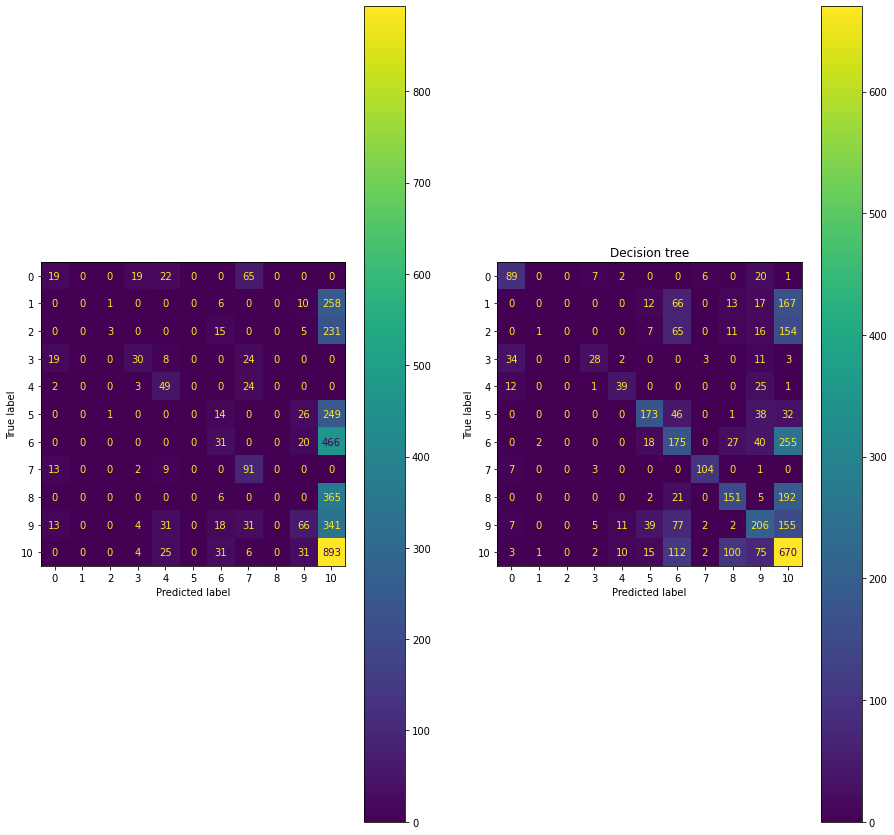

Lần lặp thứ 2:
Chỉ số tập train:  [    0     1     2 ... 17991 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    3     7    11 ... 17990 17992 17993]
Độ dài tập test:  3599
Accuracy score NB:  31.953320366768544
Accuracy score Decision tree:  46.29063628785774
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.26      0.14      0.18       125
           1       0.00      0.00      0.00       274
           2       0.00      0.00      0.00       254
           3       0.38      0.32      0.35        81
           4       0.32      0.69      0.44        78
           5       0.00      0.00      0.00       290
           6       0.27      0.05      0.09       518
           7       0.36      0.74      0.49       115
           8       0.00      0.00      0.00       370
           9       0.38      0.10      0.16       505
          10       0.31      0.90      0.47       989

    accuracy                           0.32  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

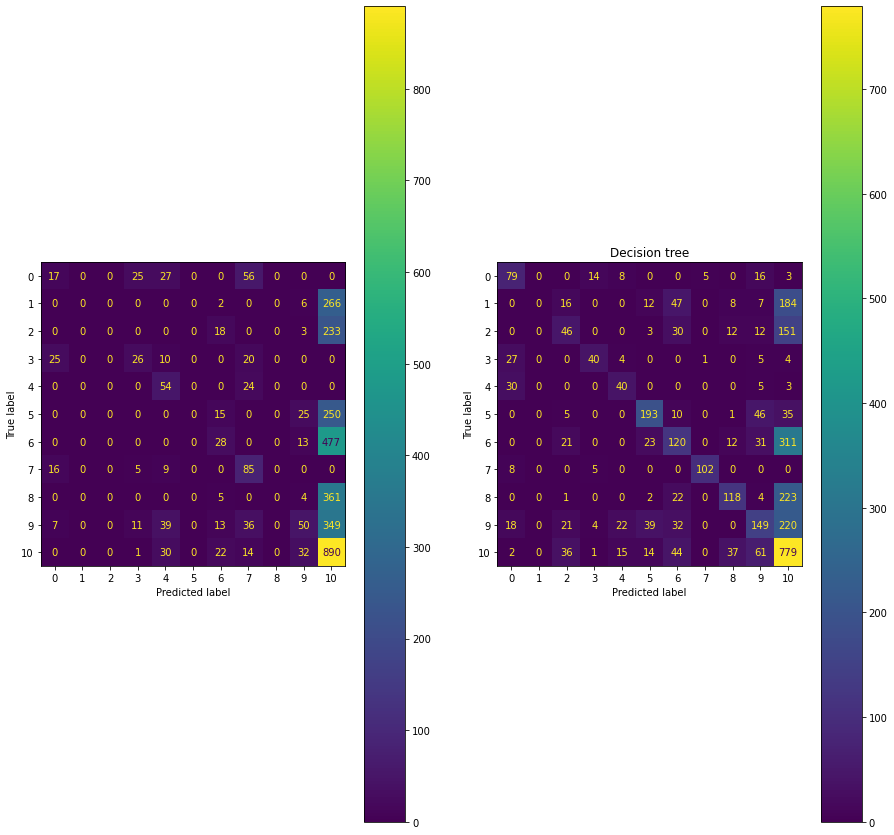

Lần lặp thứ 3:
Chỉ số tập train:  [    0     2     3 ... 17993 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    1     5    12 ... 17976 17981 17984]
Độ dài tập test:  3599
Accuracy score NB:  32.53681578216171
Accuracy score Decision tree:  45.179216449013616
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.37      0.18      0.25       125
           1       0.00      0.00      0.00       274
           2       0.00      0.00      0.00       254
           3       0.51      0.42      0.46        80
           4       0.39      0.60      0.47        77
           5       0.00      0.00      0.00       289
           6       0.21      0.07      0.10       518
           7       0.35      0.76      0.48       116
           8       0.00      0.00      0.00       371
           9       0.37      0.11      0.17       505
          10       0.32      0.90      0.47       990

    accuracy                           0.33  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


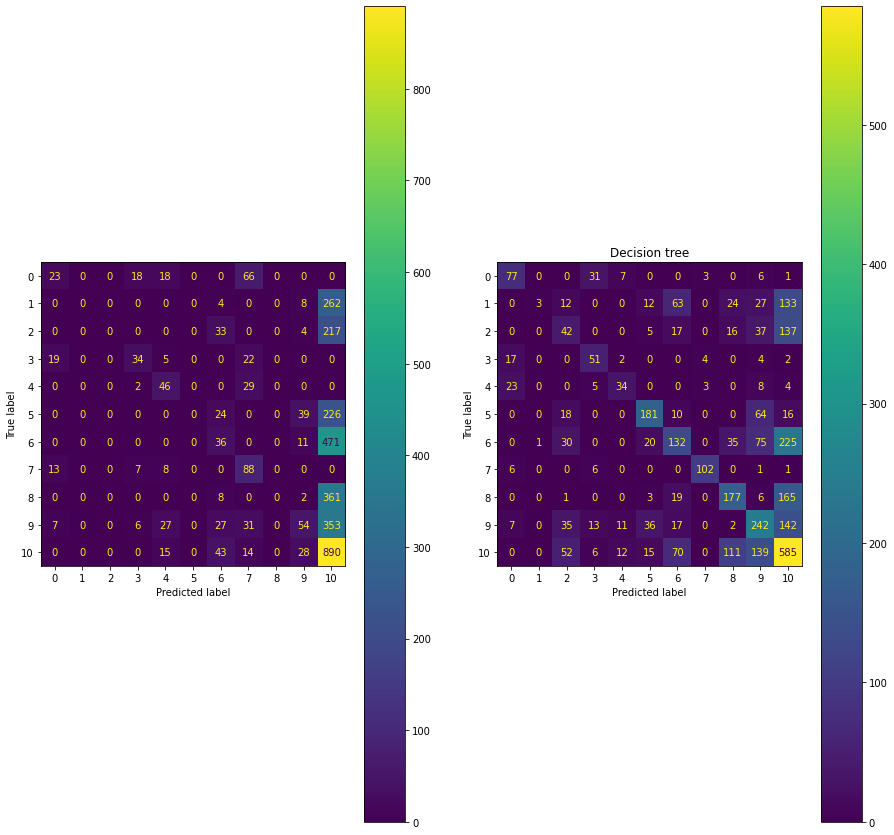

Lần lặp thứ 4:
Chỉ số tập train:  [    1     2     3 ... 17992 17993 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    0     8    16 ... 17988 17989 17994]
Độ dài tập test:  3599
Accuracy score NB:  32.37010280633509
Accuracy score Decision tree:  44.206724090025006
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.35      0.15      0.21       125
           1       0.00      0.00      0.00       275
           2       0.00      0.00      0.00       255
           3       0.48      0.49      0.48        80
           4       0.34      0.65      0.45        77
           5       0.00      0.00      0.00       289
           6       0.25      0.06      0.10       517
           7       0.35      0.70      0.46       115
           8       0.00      0.00      0.00       371
           9       0.38      0.11      0.18       505
          10       0.32      0.89      0.47       990

    accuracy                           0.32  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


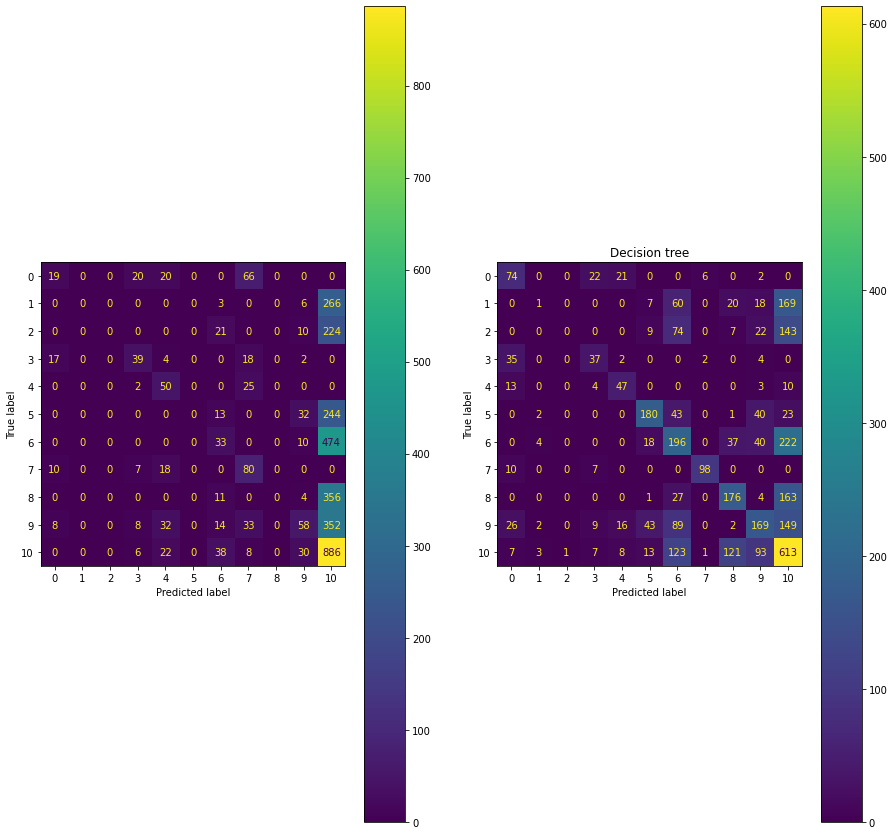

Lần lặp thứ 5:
Chỉ số tập train:  [    0     1     2 ... 17993 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    6    18    23 ... 17966 17968 17991]
Độ dài tập test:  3599
Accuracy score NB:  31.758821894970822
Accuracy score Decision tree:  44.67907752153376
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.36      0.22      0.28       125
           1       0.00      0.00      0.00       275
           2       0.00      0.00      0.00       255
           3       0.47      0.25      0.33        80
           4       0.31      0.57      0.40        77
           5       0.00      0.00      0.00       289
           6       0.19      0.06      0.09       517
           7       0.36      0.79      0.49       115
           8       0.00      0.00      0.00       371
           9       0.41      0.10      0.16       505
          10       0.31      0.89      0.46       990

    accuracy                           0.32  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

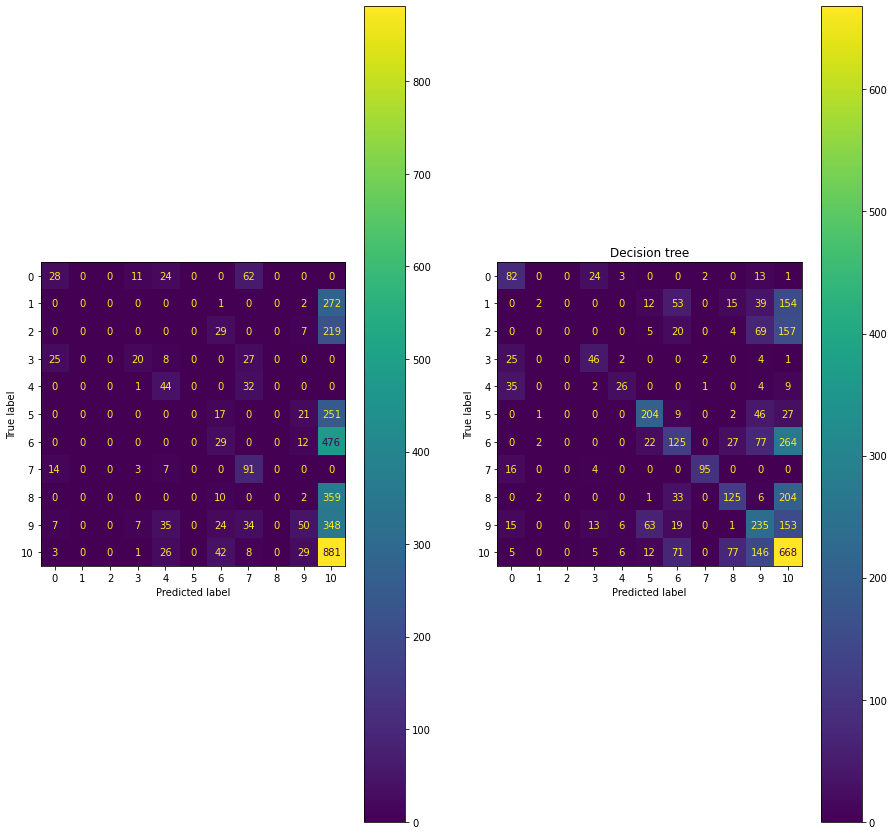

In [40]:
classification_StratifiedKFold_6_features(nb,dct,X_6,y, popularity=None, danceability=None,energy=None, speechiness=None, instrumentalness=None, duration=None)

Lần lặp thứ 1:
Chỉ số tập train:  [    0     1     3 ... 17992 17993 17994]
Độ dài tập train:  14396
Chỉ số tập test:  [    2     4     9 ... 17975 17977 17995]
Độ dài tập test:  3600
Accuracy score NB:  45.166666666666664
Accuracy score Decision tree:  45.5
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.46      0.74      0.57       125
           1       0.00      0.00      0.00       275
           2       0.30      0.20      0.24       254
           3       0.39      0.22      0.28        81
           4       0.37      0.73      0.49        78
           5       0.64      0.61      0.63       290
           6       0.47      0.22      0.30       517
           7       0.91      0.90      0.90       115
           8       0.47      0.43      0.45       371
           9       0.38      0.39      0.39       504
          10       0.43      0.66      0.52       990

    accuracy                           0.45      3600
   m

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

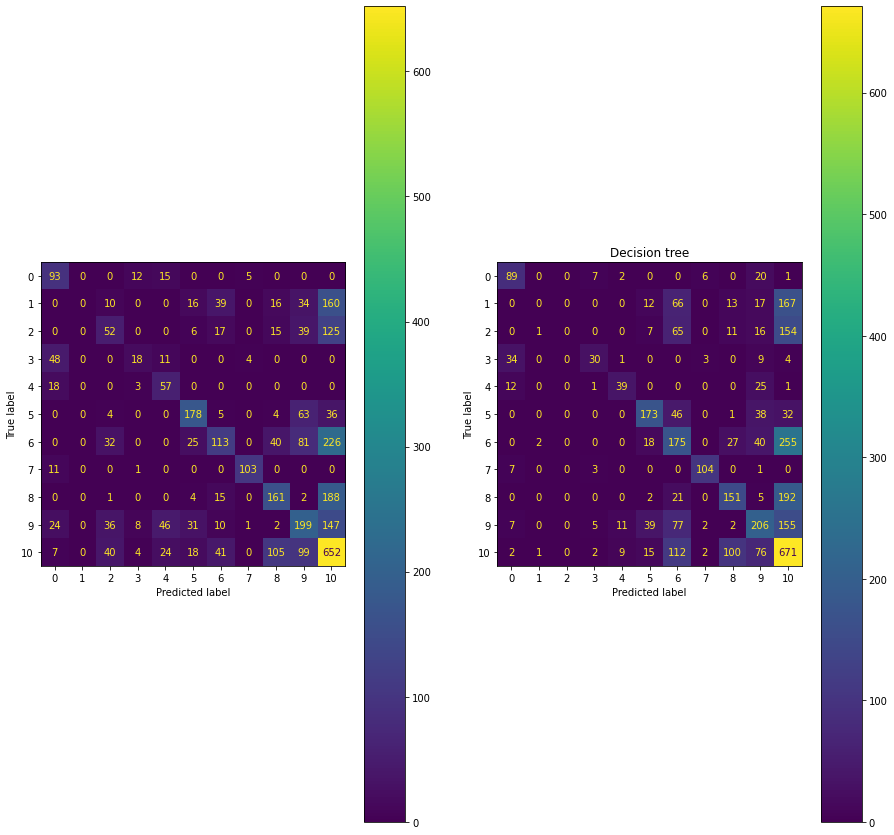

Lần lặp thứ 2:
Chỉ số tập train:  [    0     1     2 ... 17991 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    3     7    11 ... 17990 17992 17993]
Độ dài tập test:  3599
Accuracy score NB:  44.90136148930258
Accuracy score Decision tree:  46.37399277577105
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.44      0.62      0.51       125
           1       0.00      0.00      0.00       274
           2       0.30      0.20      0.24       254
           3       0.37      0.27      0.31        81
           4       0.31      0.77      0.44        78
           5       0.66      0.65      0.66       290
           6       0.45      0.20      0.28       518
           7       0.93      0.86      0.89       115
           8       0.51      0.44      0.47       370
           9       0.35      0.35      0.35       505
          10       0.43      0.68      0.53       989

    accuracy                           0.45   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

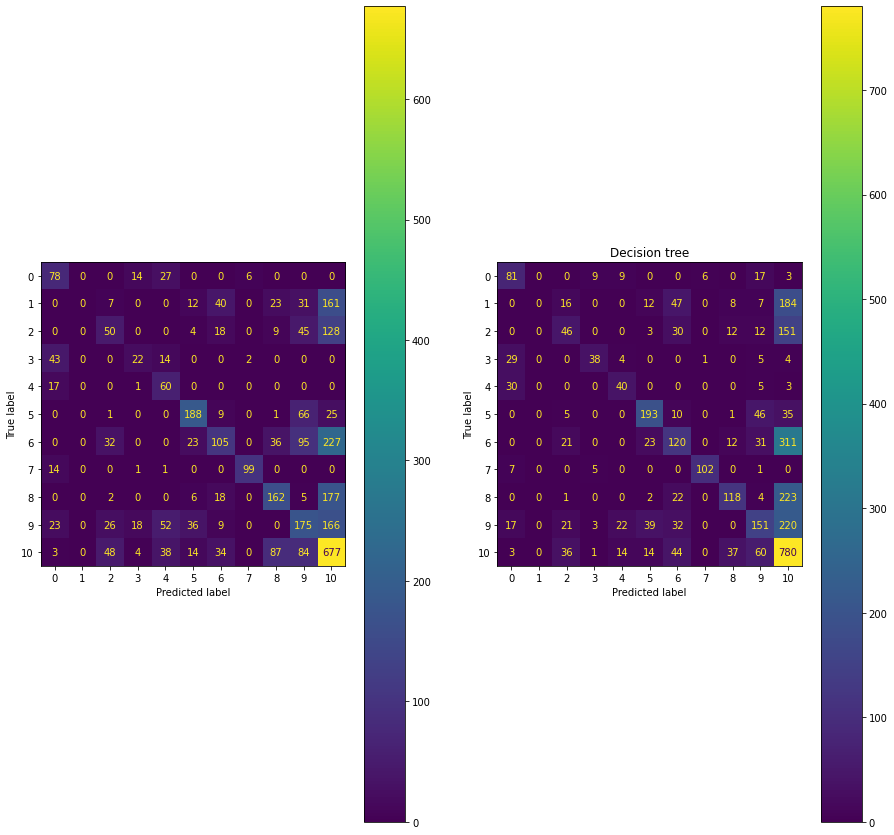

Lần lặp thứ 3:
Chỉ số tập train:  [    0     2     3 ... 17993 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    1     5    12 ... 17976 17981 17984]
Độ dài tập test:  3599
Accuracy score NB:  44.1233676021117
Accuracy score Decision tree:  45.0402889691581
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.46      0.73      0.56       125
           1       0.00      0.00      0.00       274
           2       0.24      0.17      0.20       254
           3       0.47      0.25      0.33        80
           4       0.37      0.70      0.48        77
           5       0.63      0.64      0.63       289
           6       0.44      0.22      0.30       518
           7       0.93      0.87      0.90       116
           8       0.49      0.43      0.46       371
           9       0.35      0.36      0.35       505
          10       0.42      0.65      0.51       990

    accuracy                           0.44     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


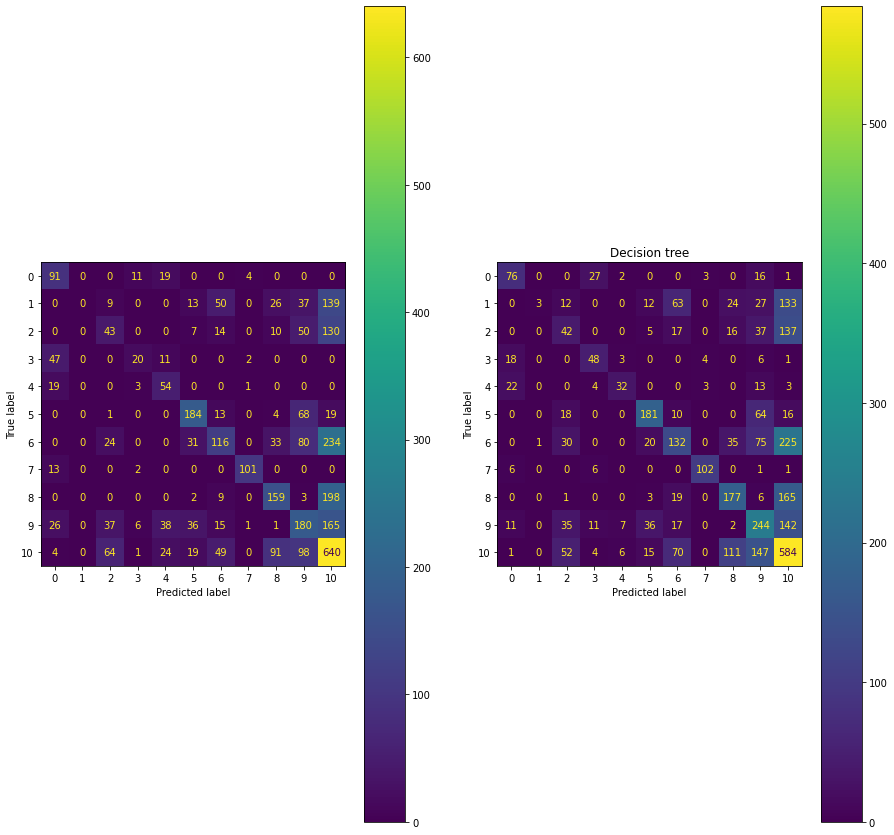

Lần lặp thứ 4:
Chỉ số tập train:  [    1     2     3 ... 17992 17993 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    0     8    16 ... 17988 17989 17994]
Độ dài tập test:  3599
Accuracy score NB:  43.901083634342875
Accuracy score Decision tree:  44.26229508196721
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.44      0.64      0.52       125
           1       0.00      0.00      0.00       275
           2       0.33      0.21      0.26       255
           3       0.49      0.35      0.41        80
           4       0.38      0.81      0.52        77
           5       0.62      0.65      0.63       289
           6       0.47      0.20      0.28       517
           7       0.90      0.86      0.88       115
           8       0.44      0.43      0.43       371
           9       0.33      0.35      0.34       505
          10       0.42      0.64      0.51       990

    accuracy                           0.44  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


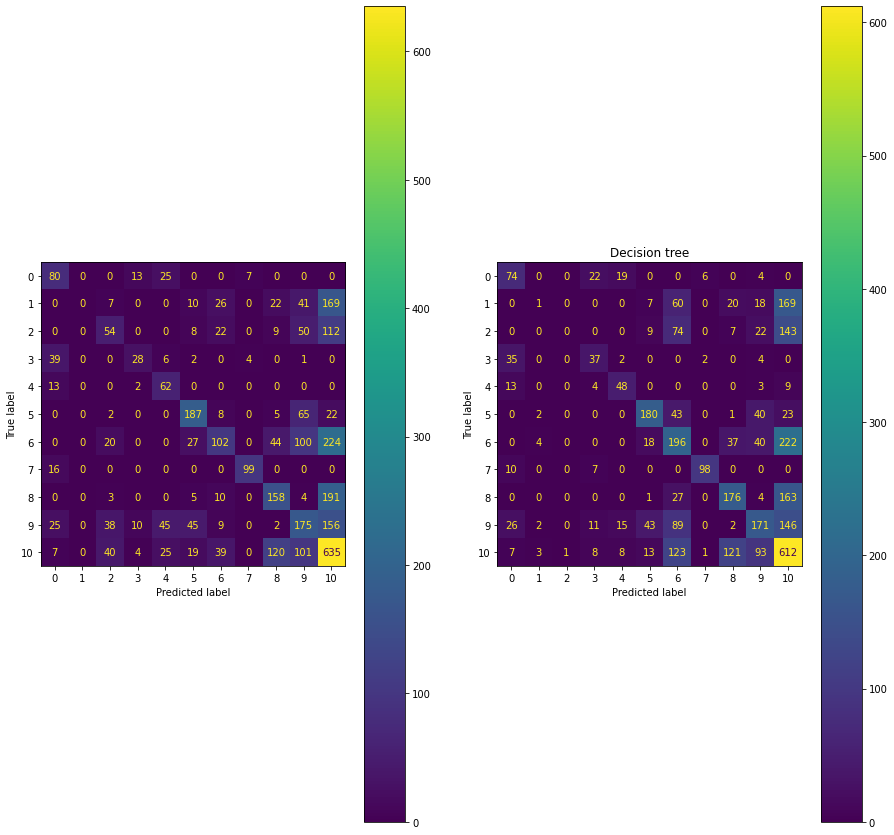

Lần lặp thứ 5:
Chỉ số tập train:  [    0     1     2 ... 17993 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    6    18    23 ... 17966 17968 17991]
Độ dài tập test:  3599
Accuracy score NB:  44.651292025562654
Accuracy score Decision tree:  44.1511530980828
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.47      0.74      0.58       125
           1       0.00      0.00      0.00       275
           2       0.34      0.18      0.24       255
           3       0.42      0.23      0.29        80
           4       0.35      0.77      0.48        77
           5       0.67      0.65      0.66       289
           6       0.44      0.22      0.29       517
           7       0.93      0.88      0.90       115
           8       0.46      0.40      0.43       371
           9       0.34      0.36      0.35       505
          10       0.42      0.66      0.52       990

    accuracy                           0.45   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

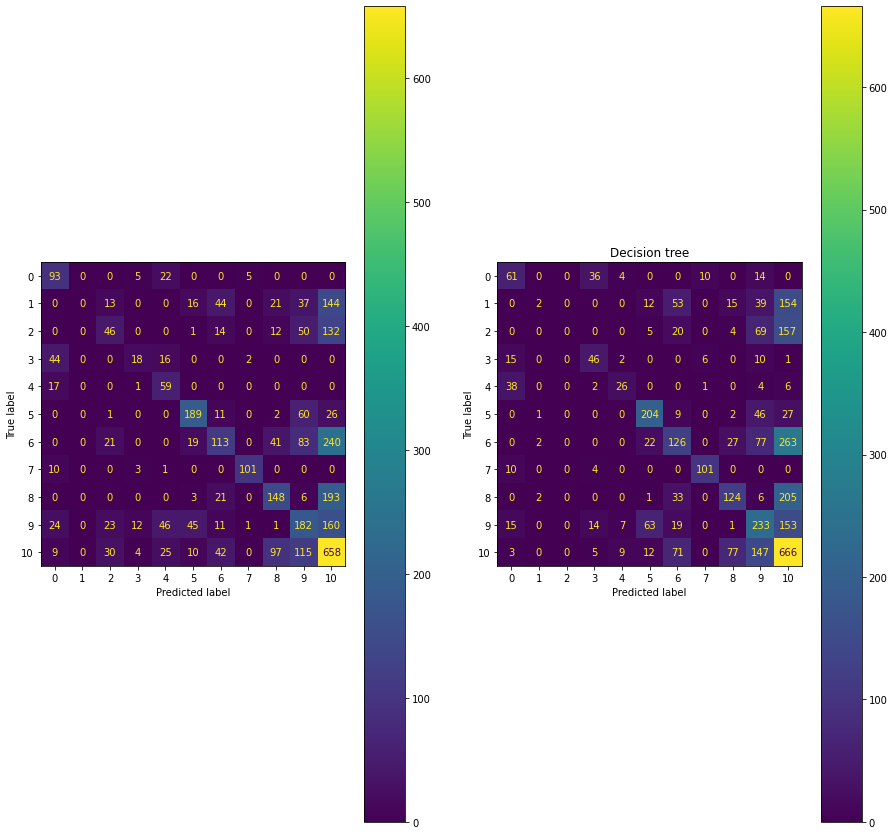

In [41]:
classification_StratifiedKFold_6_features_scale(nb,dct,X_6,y, popularity=None, danceability=None,energy=None, speechiness=None, instrumentalness=None, duration=None)

In [42]:
# Smells like teen spirit - Nirvana (Rock)
#classification_StratifiedKFold_6_features(nb, dct, X_6, y, popularity=82, danceability=0.502,energy=0.912, speechiness=0.0564, instrumentalness=0.000173, duration=301920)

In [43]:
# Break my heart - Dua Lipa (Pop)
#classification_StratifiedKFold_6_features_scale(nb, dct,X_6, y, popularity=82, danceability=0.73,energy=0.729, speechiness=0.167, instrumentalness=1.39E-06,duration=221820)

**Phân loại với Gaussian Naive Bayes với dữ liệu 8 thuộc tính**

Lần lặp thứ 1:
Chỉ số tập train:  [    0     1     3 ... 17992 17993 17994]
Độ dài tập train:  14396
Chỉ số tập test:  [    2     4     9 ... 17975 17977 17995]
Độ dài tập test:  3600
Accuracy score NB:  33.44444444444444
Accuracy score Decision tree:  46.02777777777778
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.36      0.32      0.34       125
           1       0.00      0.00      0.00       275
           2       0.38      0.02      0.04       254
           3       0.49      0.40      0.44        81
           4       0.36      0.65      0.46        78
           5       0.00      0.00      0.00       290
           6       0.25      0.07      0.11       517
           7       0.43      0.72      0.54       115
           8       0.33      0.00      0.01       371
           9       0.39      0.14      0.21       504
          10       0.32      0.89      0.47       990

    accuracy                           0.33   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

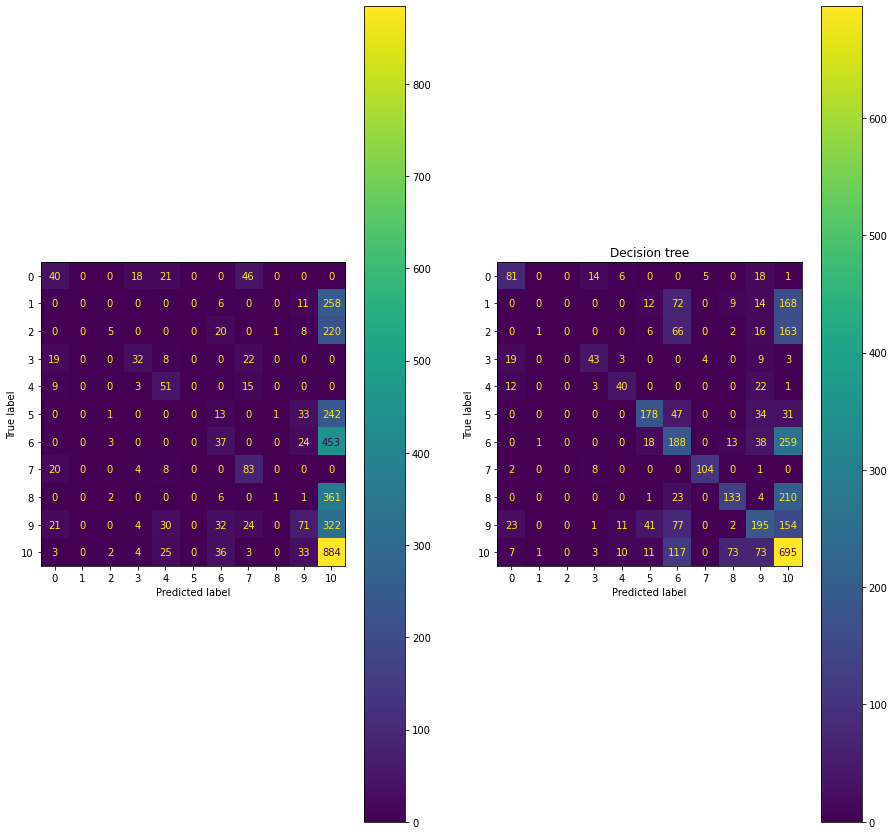

Lần lặp thứ 2:
Chỉ số tập train:  [    0     1     2 ... 17991 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    3     7    11 ... 17990 17992 17993]
Độ dài tập test:  3599
Accuracy score NB:  32.03667685468186
Accuracy score Decision tree:  46.48513475965546
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.28      0.22      0.25       125
           1       0.00      0.00      0.00       274
           2       0.29      0.01      0.02       254
           3       0.40      0.33      0.36        81
           4       0.34      0.68      0.45        78
           5       0.00      0.00      0.00       290
           6       0.23      0.08      0.12       518
           7       0.36      0.67      0.47       115
           8       0.00      0.00      0.00       370
           9       0.37      0.12      0.18       505
          10       0.32      0.88      0.47       989

    accuracy                           0.32   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

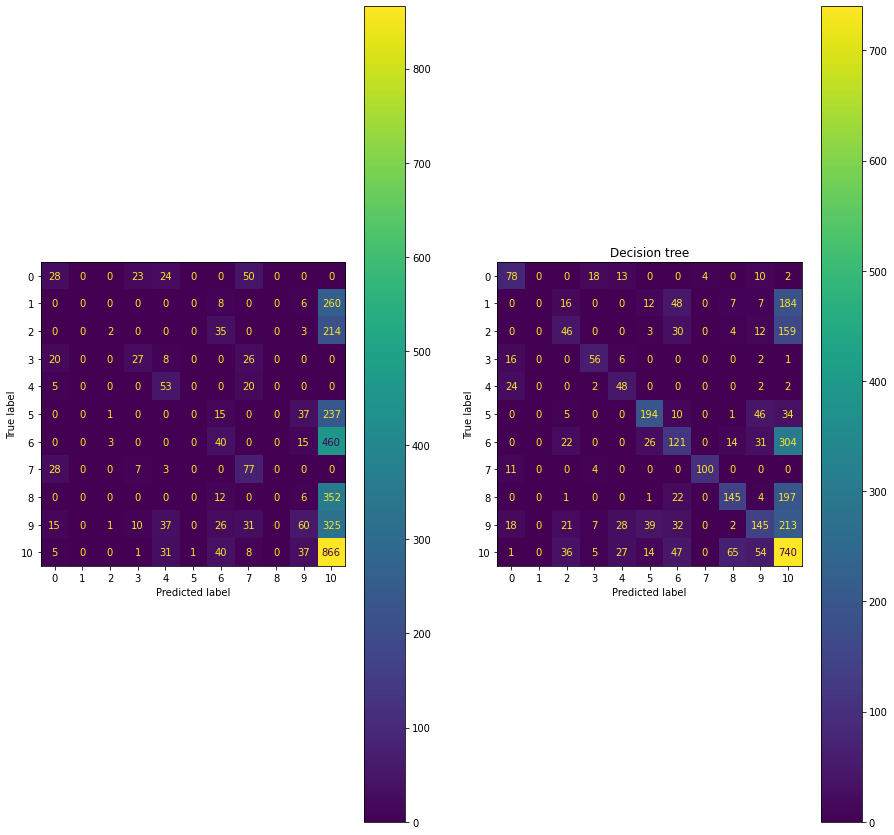

Lần lặp thứ 3:
Chỉ số tập train:  [    0     2     3 ... 17993 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    1     5    12 ... 17976 17981 17984]
Độ dài tập test:  3599
Accuracy score NB:  32.814670741872746
Accuracy score Decision tree:  45.651569880522366
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.40      0.37      0.38       125
           1       0.00      0.00      0.00       274
           2       0.25      0.00      0.01       254
           3       0.53      0.45      0.49        80
           4       0.41      0.60      0.49        77
           5       0.00      0.00      0.00       289
           6       0.19      0.08      0.11       518
           7       0.40      0.69      0.50       116
           8       0.50      0.00      0.01       371
           9       0.35      0.12      0.18       505
          10       0.32      0.88      0.47       990

    accuracy                           0.33 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


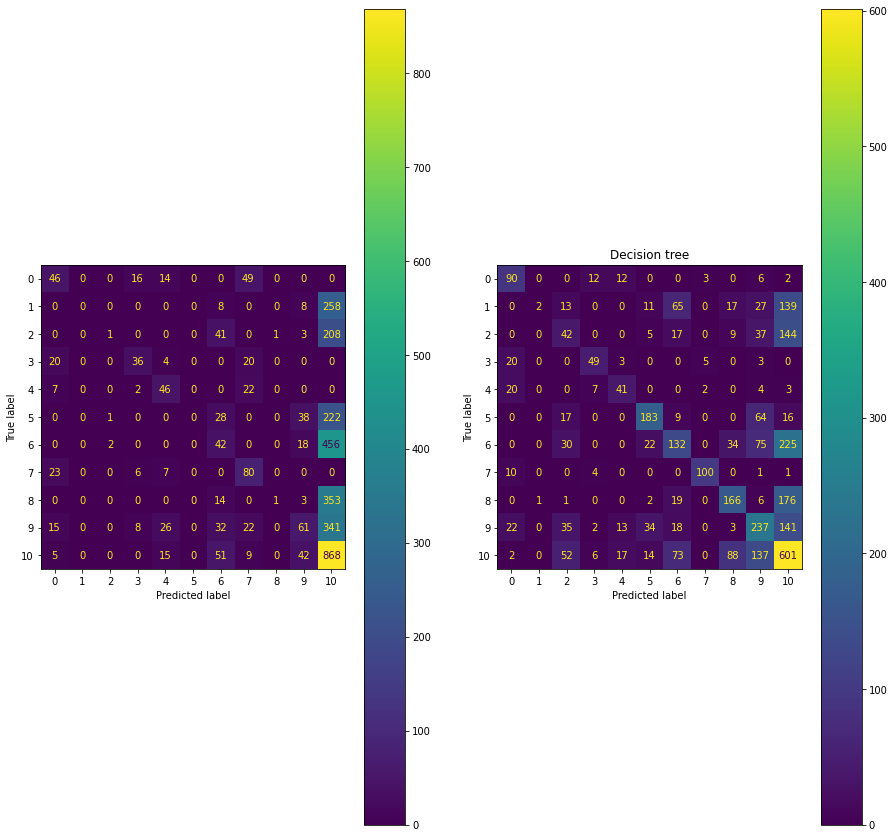

Lần lặp thứ 4:
Chỉ số tập train:  [    1     2     3 ... 17992 17993 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    0     8    16 ... 17988 17989 17994]
Độ dài tập test:  3599
Accuracy score NB:  32.84245623784385
Accuracy score Decision tree:  45.76271186440678
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.43      0.34      0.38       125
           1       0.00      0.00      0.00       275
           2       0.17      0.00      0.01       255
           3       0.51      0.47      0.49        80
           4       0.35      0.62      0.45        77
           5       0.00      0.00      0.00       289
           6       0.23      0.08      0.12       517
           7       0.38      0.66      0.48       115
           8       0.00      0.00      0.00       371
           9       0.35      0.13      0.19       505
          10       0.32      0.88      0.47       990

    accuracy                           0.33   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


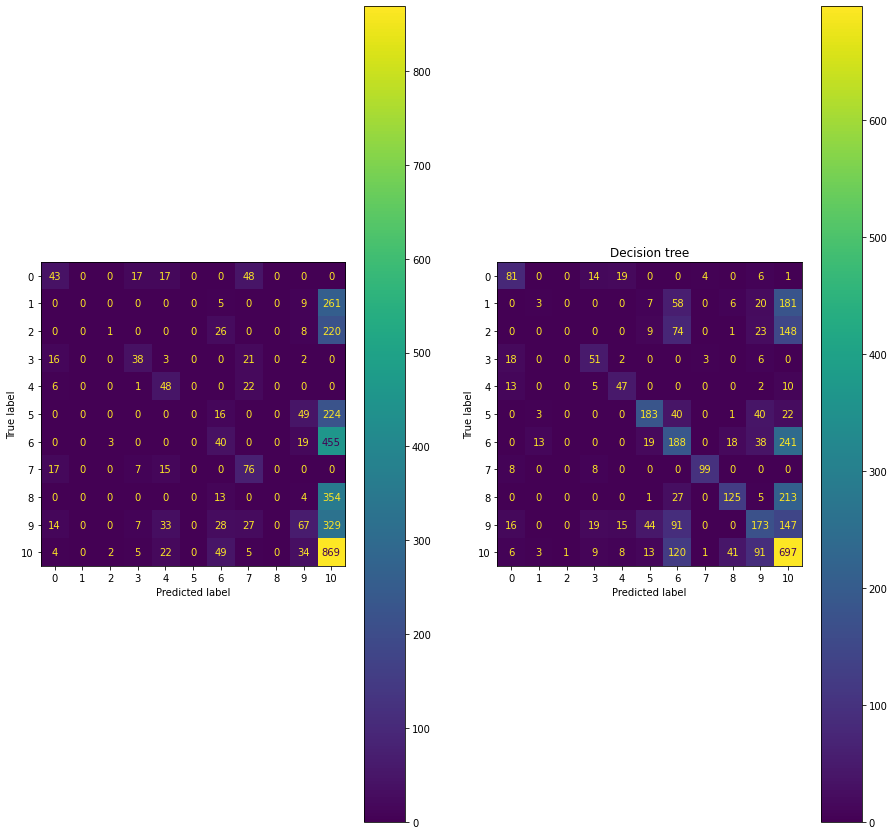

Lần lặp thứ 5:
Chỉ số tập train:  [    0     1     2 ... 17993 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    6    18    23 ... 17966 17968 17991]
Độ dài tập test:  3599
Accuracy score NB:  32.06446235065296
Accuracy score Decision tree:  45.90163934426229
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.42      0.35      0.38       125
           1       0.00      0.00      0.00       275
           2       0.11      0.00      0.01       255
           3       0.51      0.31      0.39        80
           4       0.30      0.55      0.39        77
           5       0.00      0.00      0.00       289
           6       0.23      0.09      0.12       517
           7       0.37      0.71      0.48       115
           8       1.00      0.00      0.01       371
           9       0.39      0.12      0.18       505
          10       0.31      0.86      0.46       990

    accuracy                           0.32   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

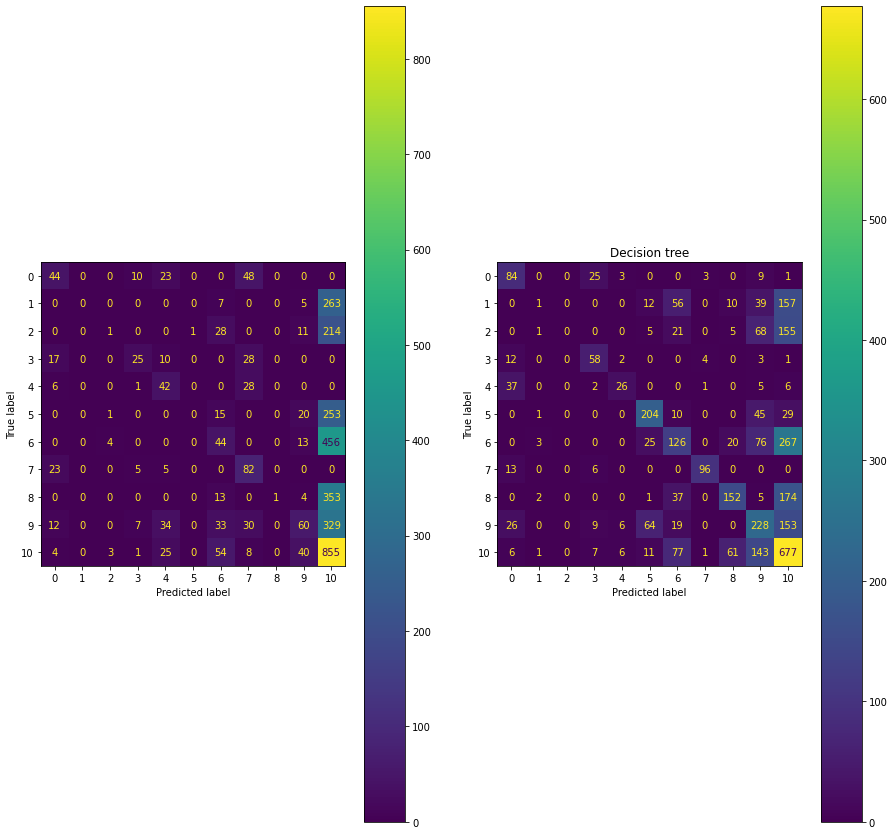

In [44]:
classification_StratifiedKFold_8_features(nb,dct,X_8,y, popularity=None, danceability=None,energy=None, speechiness=None, instrumentalness=None, valence=None, tempo=None,duration=None)

Lần lặp thứ 1:
Chỉ số tập train:  [    0     1     3 ... 17992 17993 17994]
Độ dài tập train:  14396
Chỉ số tập test:  [    2     4     9 ... 17975 17977 17995]
Độ dài tập test:  3600
Accuracy score NB:  45.69444444444444
Accuracy score Decision tree:  46.13888888888889
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.51      0.72      0.60       125
           1       0.00      0.00      0.00       275
           2       0.40      0.27      0.32       254
           3       0.48      0.42      0.45        81
           4       0.39      0.76      0.52        78
           5       0.64      0.61      0.63       290
           6       0.46      0.24      0.32       517
           7       0.87      0.89      0.88       115
           8       0.49      0.53      0.51       371
           9       0.36      0.40      0.38       504
          10       0.42      0.59      0.49       990

    accuracy                           0.46   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

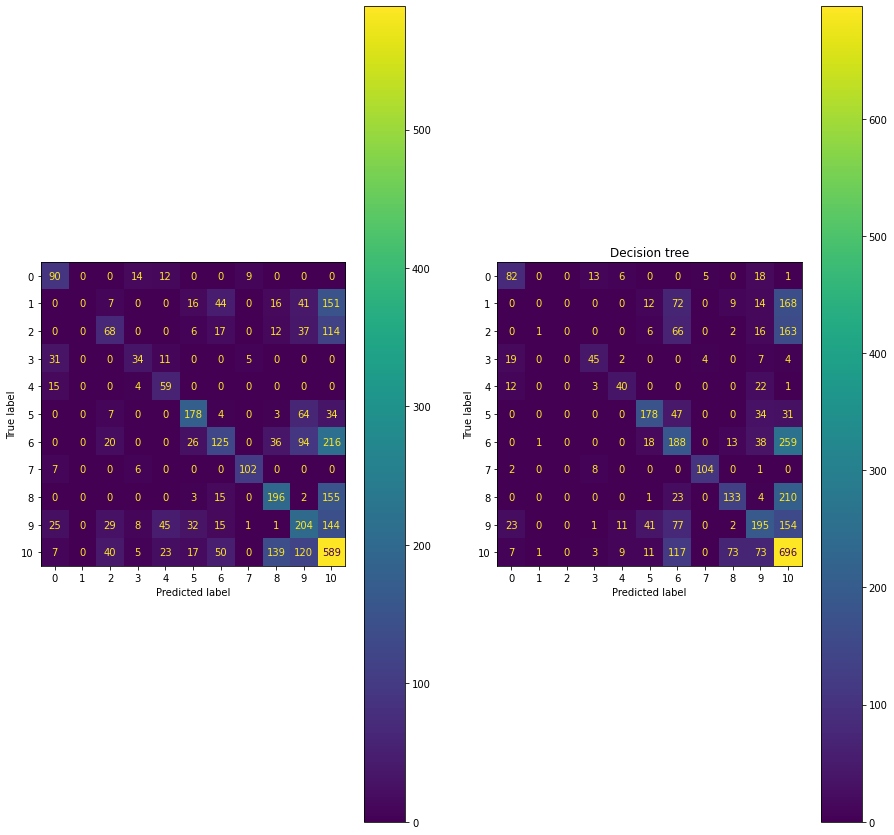

Lần lặp thứ 2:
Chỉ số tập train:  [    0     1     2 ... 17991 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    3     7    11 ... 17990 17992 17993]
Độ dài tập test:  3599
Accuracy score NB:  45.984995832175606
Accuracy score Decision tree:  46.45734926368436
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.46      0.67      0.54       125
           1       0.00      0.00      0.00       274
           2       0.48      0.23      0.31       254
           3       0.53      0.41      0.46        81
           4       0.31      0.73      0.44        78
           5       0.67      0.65      0.66       290
           6       0.45      0.22      0.30       518
           7       0.94      0.88      0.91       115
           8       0.49      0.48      0.49       370
           9       0.34      0.37      0.35       505
          10       0.44      0.66      0.53       989

    accuracy                           0.46  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

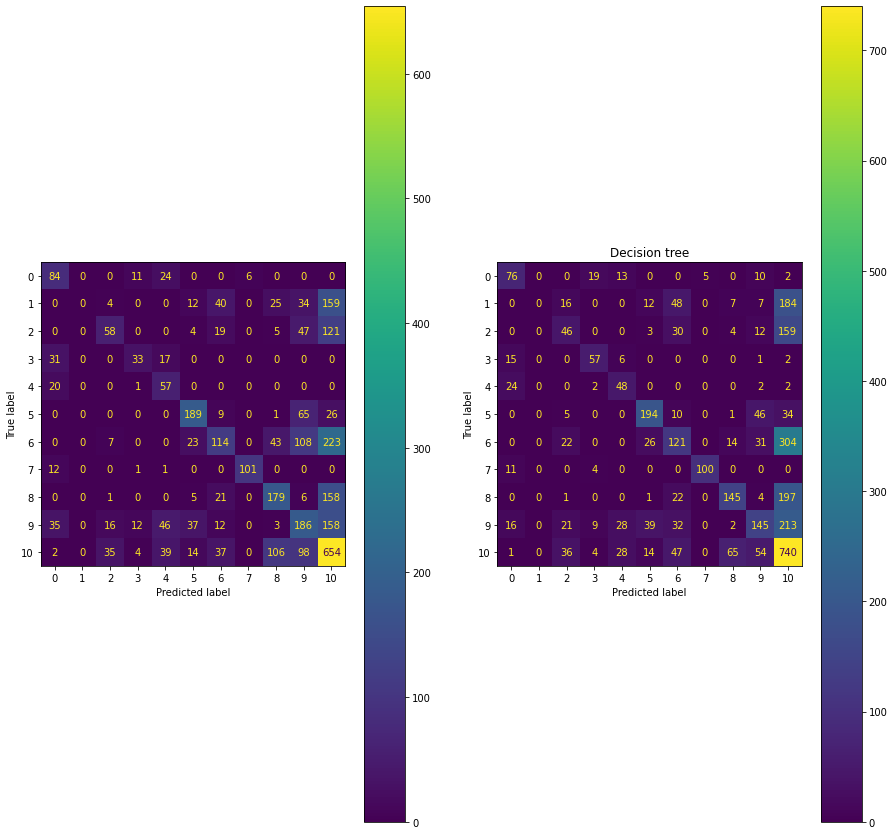

Lần lặp thứ 3:
Chỉ số tập train:  [    0     2     3 ... 17993 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    1     5    12 ... 17976 17981 17984]
Độ dài tập test:  3599
Accuracy score NB:  44.317866073909414
Accuracy score Decision tree:  45.623784384551264
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.52      0.74      0.61       125
           1       0.00      0.00      0.00       274
           2       0.32      0.19      0.23       254
           3       0.64      0.46      0.54        80
           4       0.36      0.71      0.48        77
           5       0.63      0.63      0.63       289
           6       0.40      0.22      0.28       518
           7       0.92      0.85      0.88       116
           8       0.49      0.49      0.49       371
           9       0.34      0.38      0.36       505
          10       0.41      0.60      0.49       990

    accuracy                           0.44 

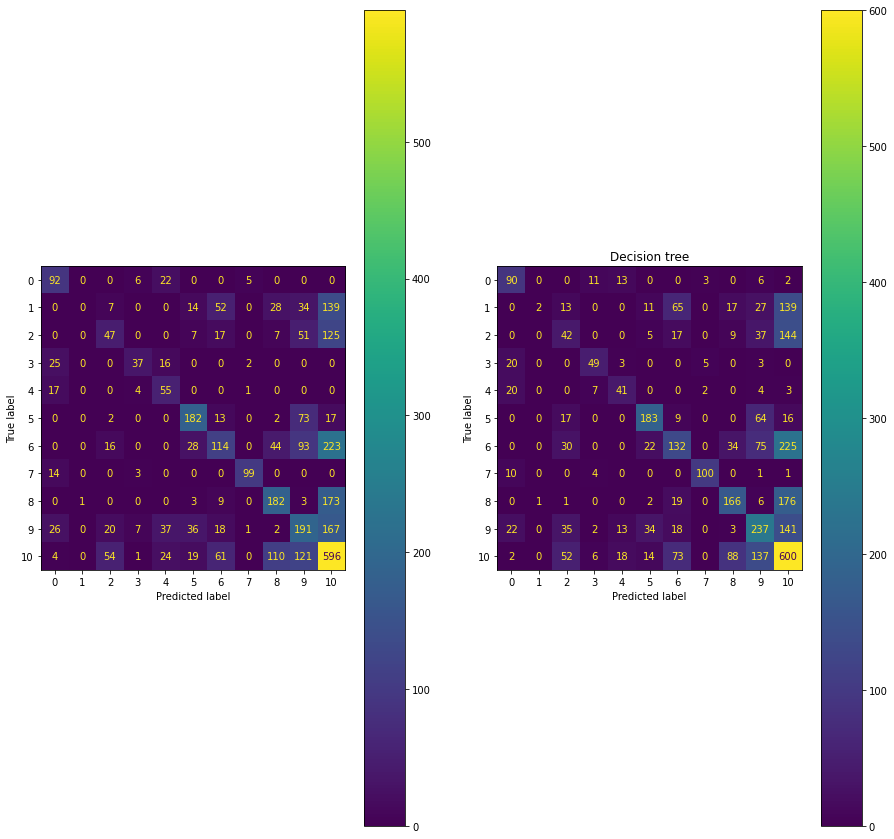

Lần lặp thứ 4:
Chỉ số tập train:  [    1     2     3 ... 17992 17993 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    0     8    16 ... 17988 17989 17994]
Độ dài tập test:  3599
Accuracy score NB:  45.20700194498472
Accuracy score Decision tree:  46.06835232008891
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.51      0.70      0.59       125
           1       0.00      0.00      0.00       275
           2       0.36      0.21      0.26       255
           3       0.52      0.45      0.48        80
           4       0.40      0.82      0.54        77
           5       0.63      0.66      0.64       289
           6       0.44      0.21      0.29       517
           7       0.90      0.89      0.89       115
           8       0.49      0.51      0.50       371
           9       0.33      0.37      0.35       505
          10       0.42      0.62      0.50       990

    accuracy                           0.45   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


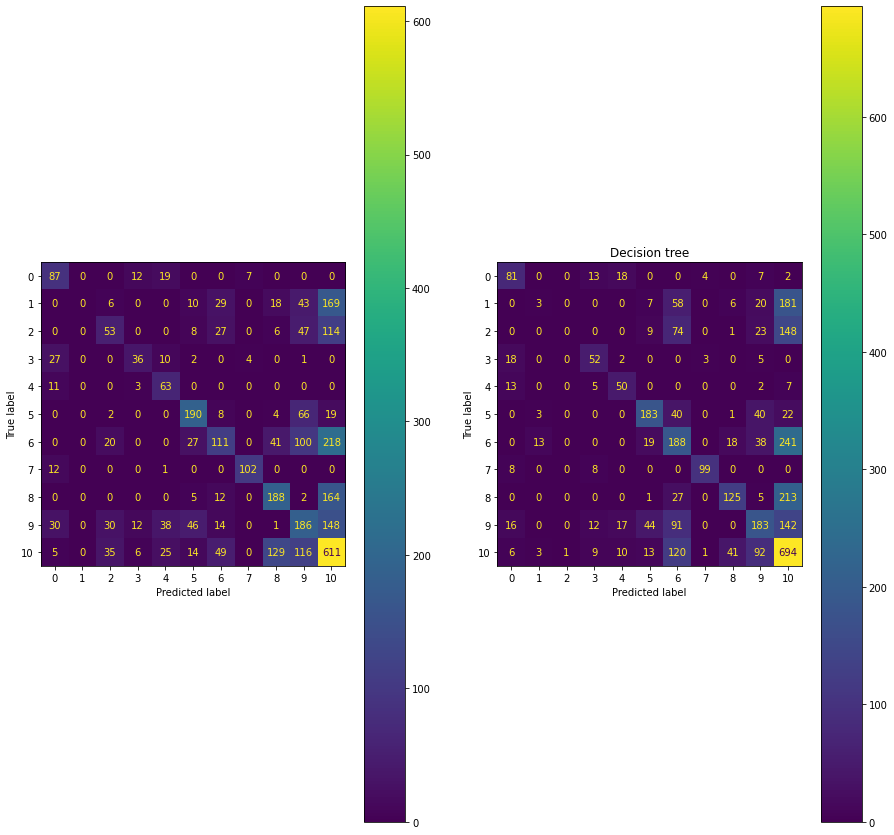

Lần lặp thứ 5:
Chỉ số tập train:  [    0     1     2 ... 17993 17994 17995]
Độ dài tập train:  14397
Chỉ số tập test:  [    6    18    23 ... 17966 17968 17991]
Độ dài tập test:  3599
Accuracy score NB:  46.17949430397333
Accuracy score Decision tree:  46.45734926368436
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.49      0.72      0.59       125
           1       0.00      0.00      0.00       275
           2       0.49      0.22      0.30       255
           3       0.50      0.36      0.42        80
           4       0.35      0.74      0.48        77
           5       0.66      0.64      0.65       289
           6       0.43      0.24      0.31       517
           7       0.88      0.90      0.89       115
           8       0.51      0.53      0.52       371
           9       0.33      0.37      0.35       505
          10       0.44      0.64      0.52       990

    accuracy                           0.46   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

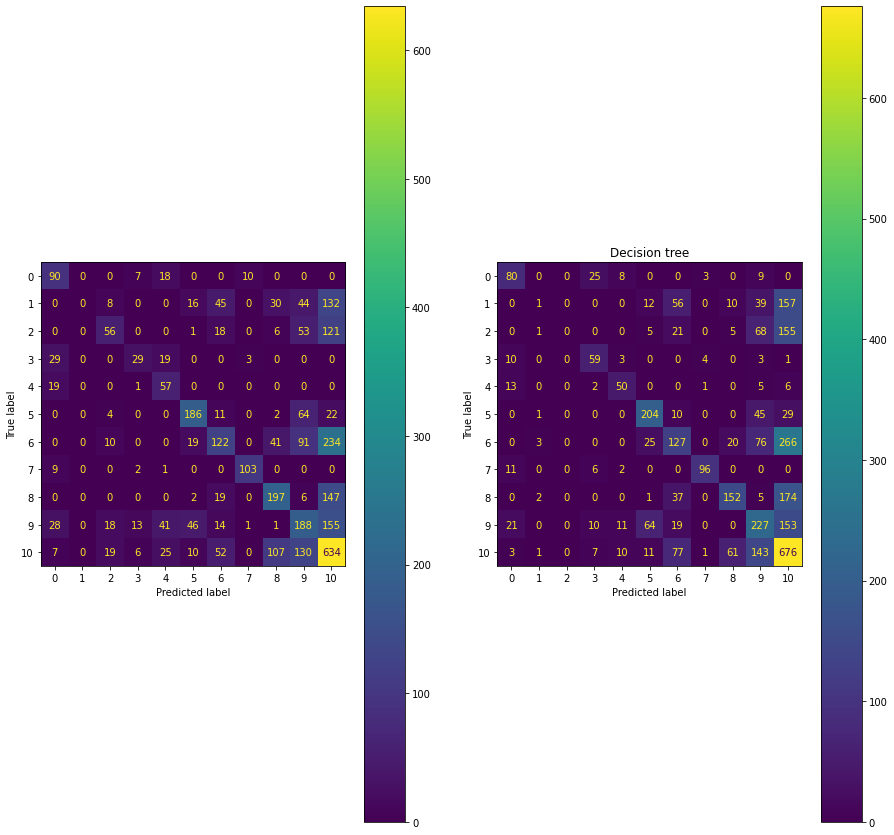

In [45]:
classification_StratifiedKFold_8_features_scale(nb,dct,X_8,y, popularity=None, danceability=None,energy=None, speechiness=None, instrumentalness=None, valence=None, tempo=None,duration=None)

In [46]:
# Smells like teen spirit - Nirvana (Rock)
#classification_StratifiedKFold_8_features(nb,dct,X_8,y, popularity=82, danceability=0.502,energy=0.912, speechiness=0.0564, instrumentalness=0.000173, valence=0.72, tempo=116.761,duration=301920)

**Phân loại với Gaussian Naive Bayes với dữ liệu đã cân bằng**

Lần lặp thứ 1:
Chỉ số tập train:  [    1     3     5 ... 54435 54437 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [    0     2     4 ... 54424 54427 54436]
Độ dài tập test:  10888
Accuracy score NB:  33.58743570903747
Accuracy score Decision tree:  55.49228508449669
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.36      0.03      0.06       990
           1       0.20      0.51      0.29       989
           2       0.28      0.55      0.37       990
           3       0.56      0.59      0.58       990
           4       0.54      0.67      0.60       989
           5       0.26      0.27      0.26       990
           6       0.00      0.00      0.00       990
           7       0.38      0.68      0.49       990
           8       0.35      0.21      0.26       990
           9       0.27      0.13      0.17       990
          10       0.28      0.05      0.09       990

    accuracy                           0.34  

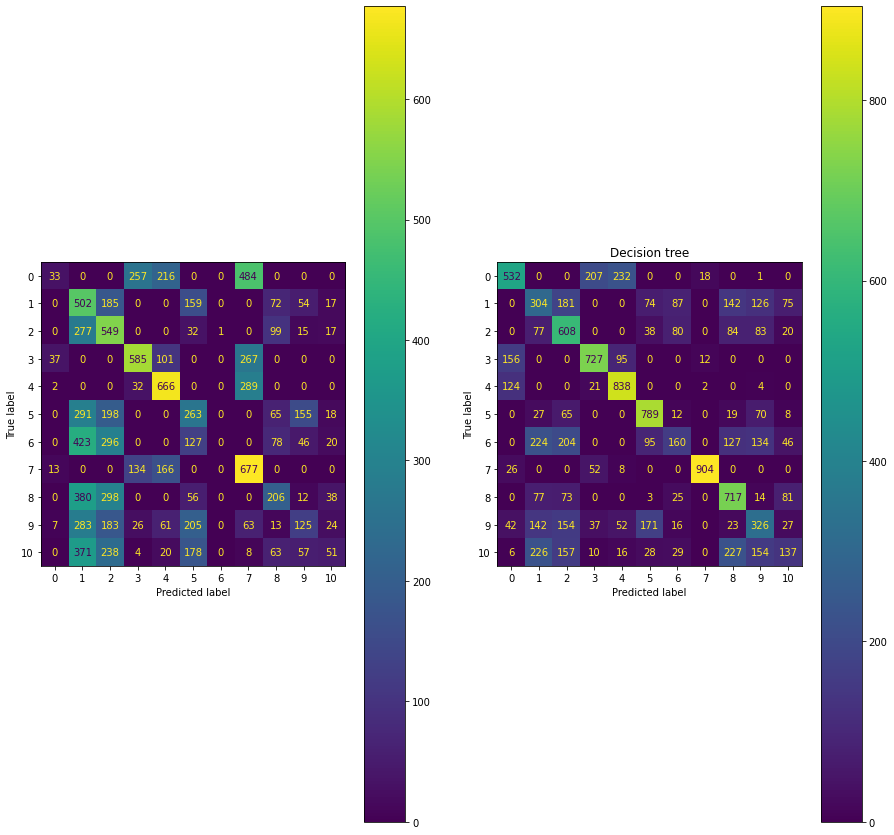

Lần lặp thứ 2:
Chỉ số tập train:  [    0     1     2 ... 54435 54436 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [   12    19    20 ... 54425 54434 54437]
Độ dài tập test:  10888
Accuracy score NB:  32.9261572373255
Accuracy score Decision tree:  55.18919911829537
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.28      0.03      0.05       990
           1       0.20      0.54      0.30       990
           2       0.27      0.55      0.37       989
           3       0.55      0.54      0.55       990
           4       0.51      0.69      0.59       990
           5       0.28      0.25      0.27       990
           6       0.00      0.00      0.00       990
           7       0.36      0.65      0.47       989
           8       0.32      0.20      0.25       990
           9       0.26      0.12      0.16       990
          10       0.28      0.04      0.07       990

    accuracy                           0.33   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


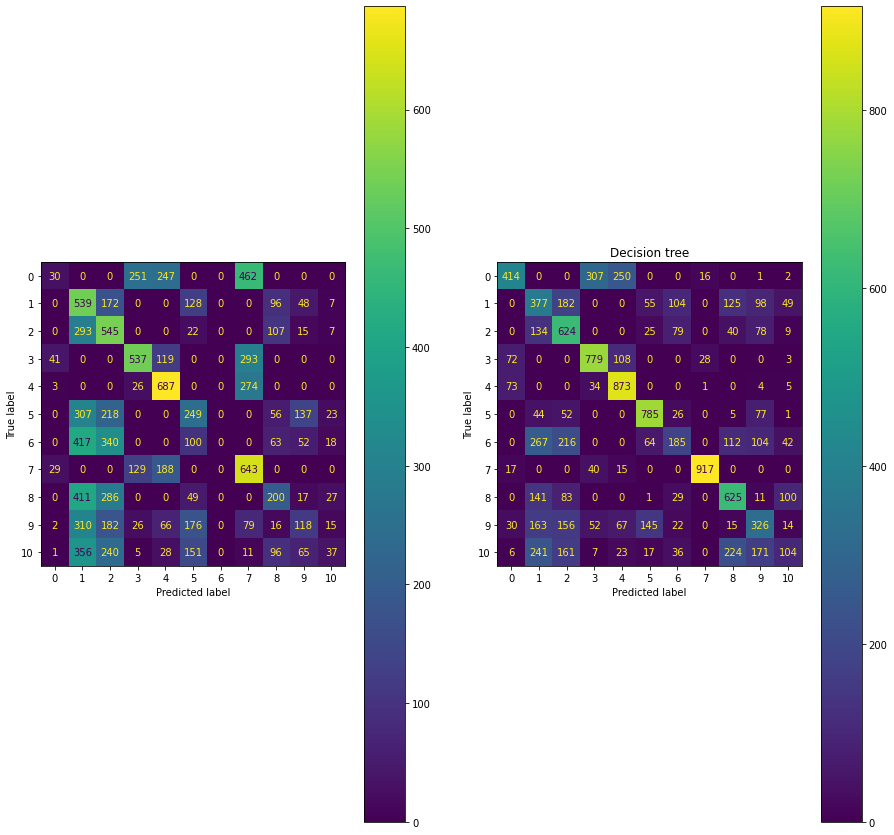

Lần lặp thứ 3:
Chỉ số tập train:  [    0     2     3 ... 54435 54436 54437]
Độ dài tập train:  43551
Chỉ số tập test:  [    1     8    10 ... 54432 54433 54438]
Độ dài tập test:  10888
Accuracy score NB:  34.184423218221895
Accuracy score Decision tree:  56.07090374724467
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.25      0.02      0.04       990
           1       0.20      0.52      0.29       990
           2       0.28      0.56      0.38       990
           3       0.59      0.59      0.59       989
           4       0.56      0.72      0.63       990
           5       0.26      0.26      0.26       990
           6       0.00      0.00      0.00       989
           7       0.39      0.71      0.51       990
           8       0.32      0.21      0.25       990
           9       0.27      0.12      0.16       990
          10       0.36      0.05      0.09       990

    accuracy                           0.34 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


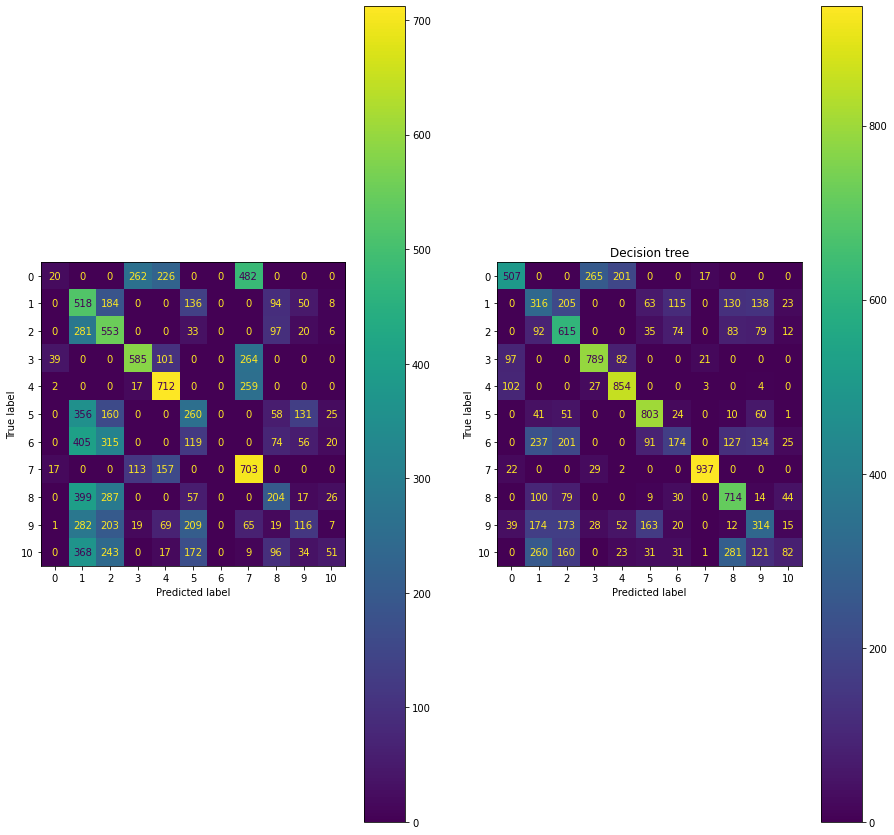

Lần lặp thứ 4:
Chỉ số tập train:  [    0     1     2 ... 54436 54437 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [    9    13    21 ... 54410 54428 54431]
Độ dài tập test:  10888
Accuracy score NB:  33.89970609845702
Accuracy score Decision tree:  54.757531227038946
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.31      0.03      0.05       990
           1       0.20      0.52      0.29       990
           2       0.29      0.56      0.39       990
           3       0.56      0.58      0.57       990
           4       0.55      0.71      0.62       990
           5       0.24      0.24      0.24       990
           6       0.38      0.00      0.01       990
           7       0.40      0.71      0.51       990
           8       0.34      0.22      0.27       990
           9       0.23      0.11      0.14       989
          10       0.33      0.06      0.10       989

    accuracy                           0.34 

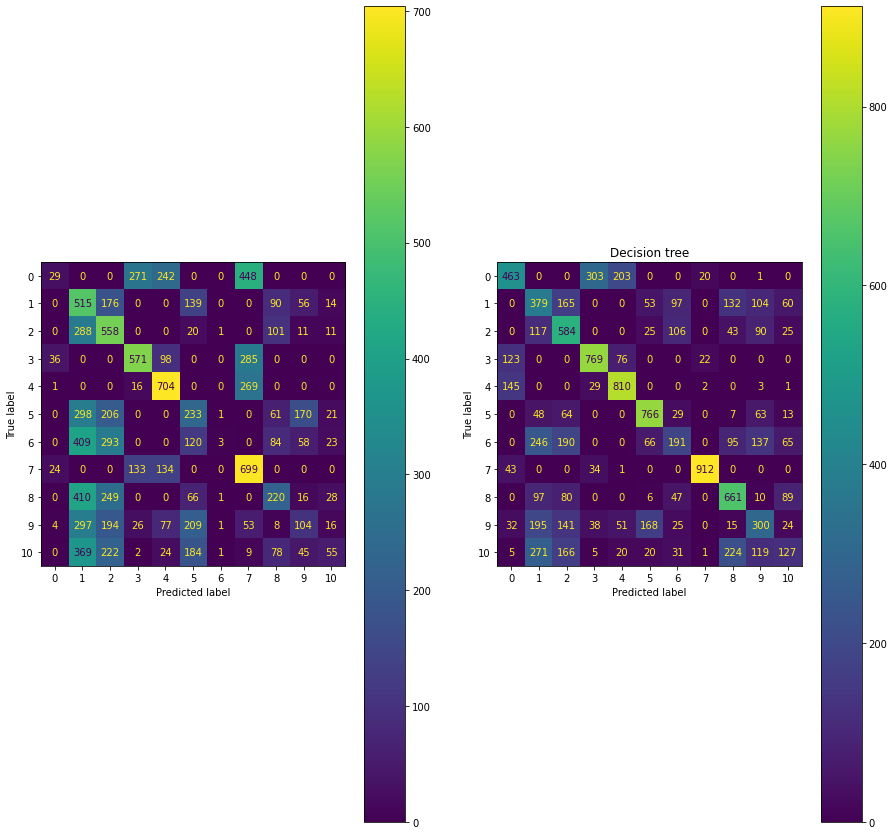

Lần lặp thứ 5:
Chỉ số tập train:  [    0     1     2 ... 54436 54437 54438]
Độ dài tập train:  43552
Chỉ số tập test:  [    3     5     6 ... 54421 54426 54435]
Độ dài tập test:  10887
Accuracy score NB:  33.02103426104529
Accuracy score Decision tree:  55.44227059796087
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.33      0.03      0.05       989
           1       0.20      0.51      0.29       990
           2       0.28      0.54      0.37       990
           3       0.56      0.58      0.57       990
           4       0.53      0.73      0.61       990
           5       0.23      0.21      0.22       989
           6       0.00      0.00      0.00       990
           7       0.38      0.67      0.49       990
           8       0.29      0.21      0.24       989
           9       0.23      0.10      0.14       990
          10       0.29      0.05      0.08       990

    accuracy                           0.33  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


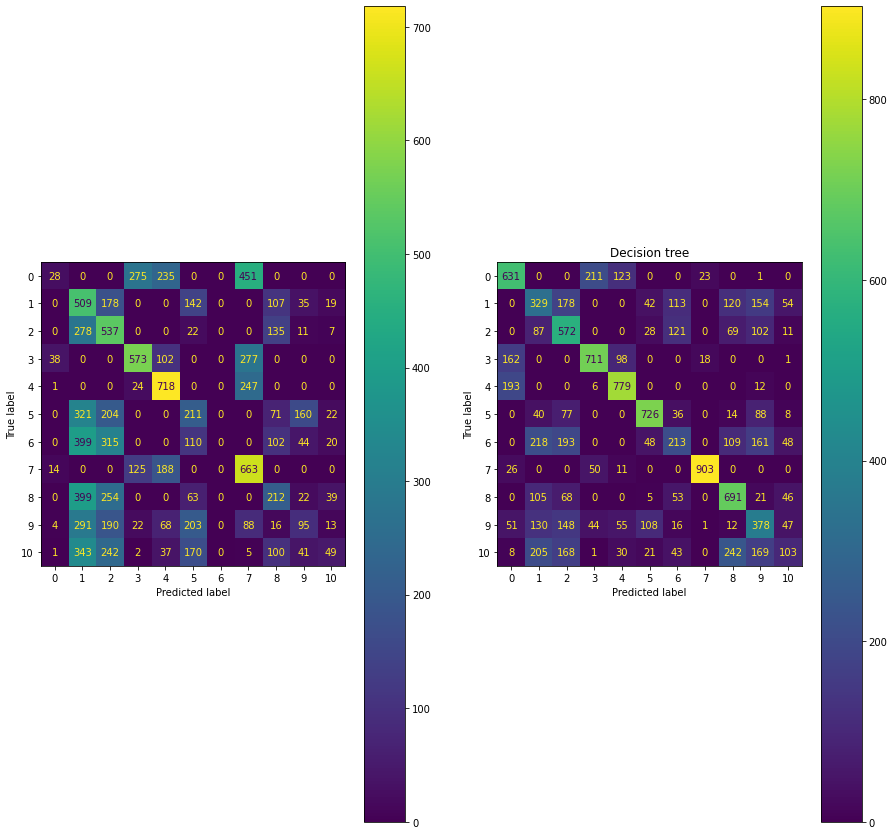

In [47]:
classification_StratifiedKFold_6_features(nb, dct,X_sm_6, y_sm_6, popularity=None, danceability=None,energy=None, speechiness=None, instrumentalness=None, duration=None)

Lần lặp thứ 1:
Chỉ số tập train:  [    1     3     5 ... 54435 54437 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [    0     2     4 ... 54424 54427 54436]
Độ dài tập test:  10888
Accuracy score NB:  52.3879500367377
Accuracy score Decision tree:  54.8218221895665
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.47      0.67      0.55       990
           1       0.30      0.23      0.26       989
           2       0.41      0.64      0.50       990
           3       0.65      0.37      0.47       990
           4       0.62      0.78      0.69       989
           5       0.71      0.74      0.73       990
           6       0.39      0.18      0.24       990
           7       0.96      0.90      0.93       990
           8       0.52      0.74      0.61       990
           9       0.33      0.34      0.33       990
          10       0.33      0.18      0.23       990

    accuracy                           0.52    

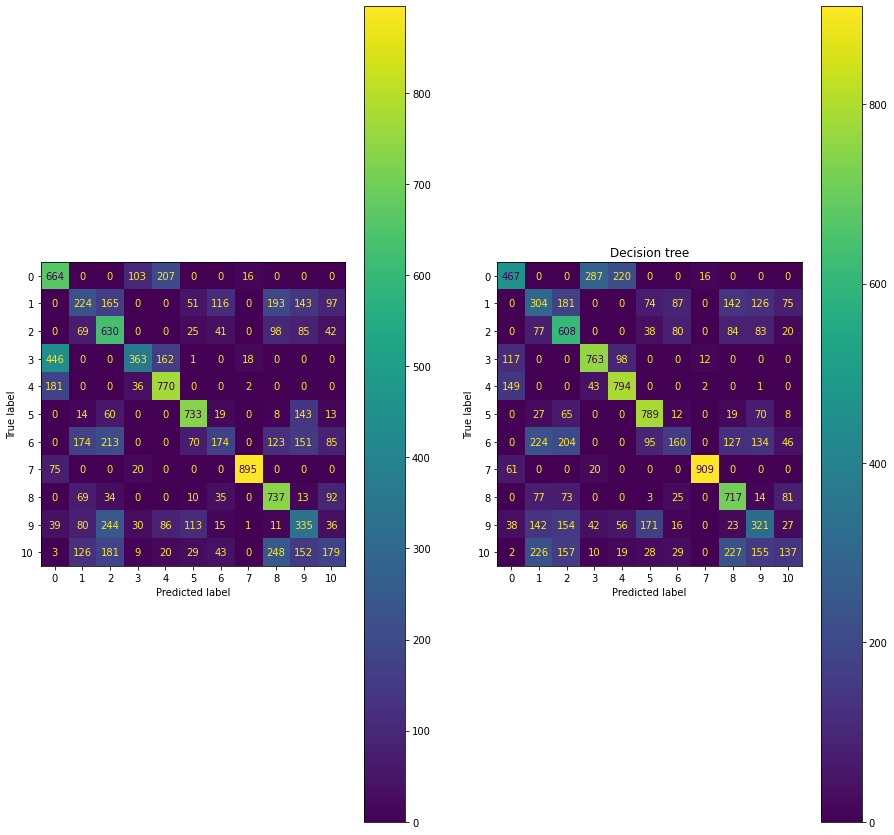

Lần lặp thứ 2:
Chỉ số tập train:  [    0     1     2 ... 54435 54436 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [   12    19    20 ... 54425 54434 54437]
Độ dài tập test:  10888
Accuracy score NB:  52.32365907421014
Accuracy score Decision tree:  55.0330639235856
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.47      0.64      0.54       990
           1       0.29      0.23      0.26       990
           2       0.41      0.65      0.50       989
           3       0.62      0.35      0.44       990
           4       0.60      0.80      0.69       990
           5       0.73      0.77      0.75       990
           6       0.42      0.19      0.27       990
           7       0.96      0.92      0.94       989
           8       0.52      0.72      0.60       990
           9       0.32      0.33      0.32       990
          10       0.33      0.16      0.21       990

    accuracy                           0.52   

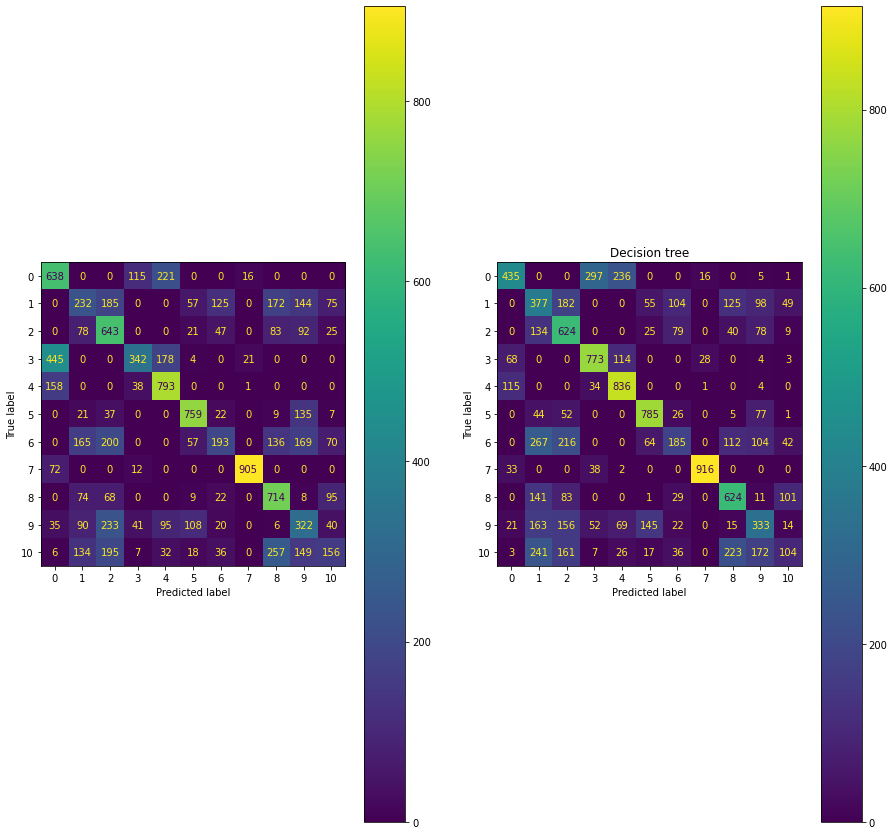

Lần lặp thứ 3:
Chỉ số tập train:  [    0     2     3 ... 54435 54436 54437]
Độ dài tập train:  43551
Chỉ số tập test:  [    1     8    10 ... 54432 54433 54438]
Độ dài tập test:  10888
Accuracy score NB:  53.30639235855988
Accuracy score Decision tree:  55.3269654665687
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.49      0.64      0.56       990
           1       0.32      0.21      0.25       990
           2       0.39      0.64      0.49       990
           3       0.66      0.38      0.48       989
           4       0.62      0.83      0.71       990
           5       0.75      0.75      0.75       990
           6       0.38      0.18      0.25       989
           7       0.96      0.93      0.95       990
           8       0.52      0.76      0.61       990
           9       0.34      0.36      0.35       990
          10       0.35      0.19      0.24       990

    accuracy                           0.53   

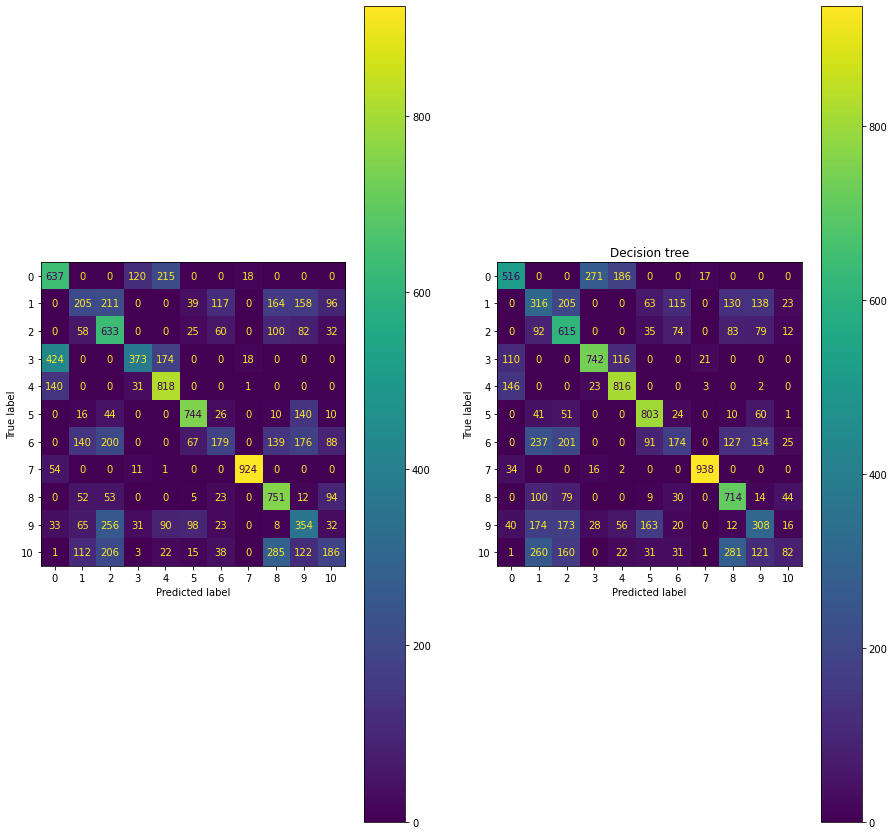

Lần lặp thứ 4:
Chỉ số tập train:  [    0     1     2 ... 54436 54437 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [    9    13    21 ... 54410 54428 54431]
Độ dài tập test:  10888
Accuracy score NB:  52.3879500367377
Accuracy score Decision tree:  54.56465833945629
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.46      0.63      0.53       990
           1       0.30      0.22      0.25       990
           2       0.41      0.66      0.51       990
           3       0.62      0.35      0.45       990
           4       0.61      0.82      0.70       990
           5       0.71      0.75      0.73       990
           6       0.40      0.18      0.25       990
           7       0.95      0.90      0.93       990
           8       0.52      0.74      0.61       990
           9       0.33      0.34      0.34       989
          10       0.36      0.18      0.24       989

    accuracy                           0.52   

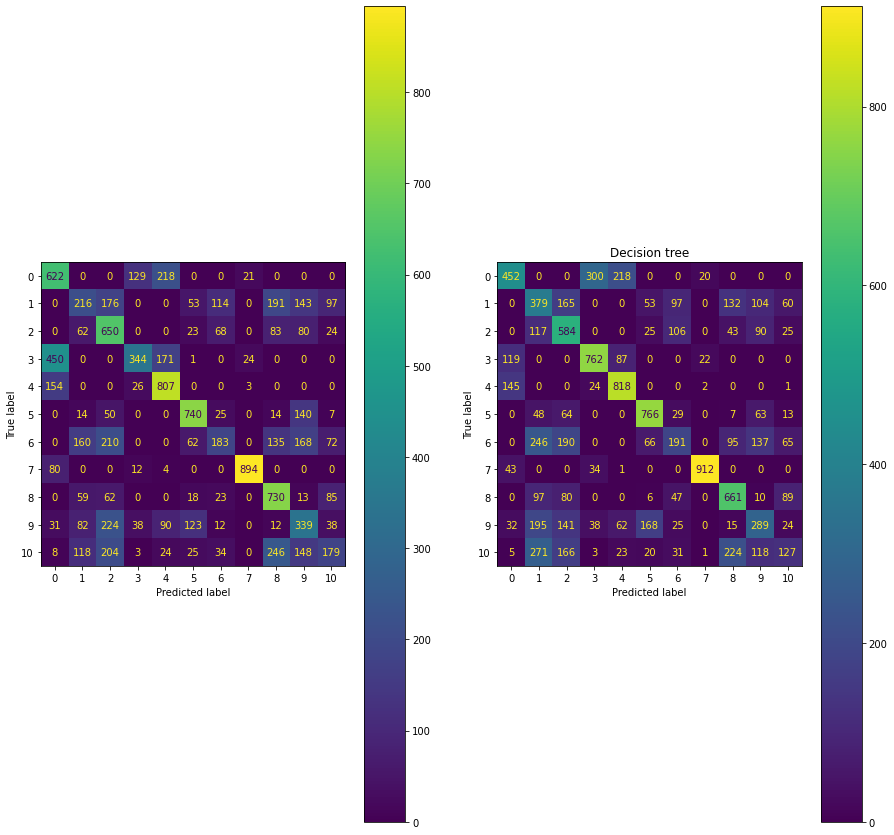

Lần lặp thứ 5:
Chỉ số tập train:  [    0     1     2 ... 54436 54437 54438]
Độ dài tập train:  43552
Chỉ số tập test:  [    3     5     6 ... 54421 54426 54435]
Độ dài tập test:  10887
Accuracy score NB:  52.71424634885643
Accuracy score Decision tree:  55.120786258840816
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.48      0.65      0.55       989
           1       0.29      0.20      0.24       990
           2       0.42      0.67      0.52       990
           3       0.62      0.34      0.44       990
           4       0.59      0.81      0.68       990
           5       0.75      0.76      0.76       989
           6       0.44      0.20      0.27       990
           7       0.95      0.91      0.93       990
           8       0.51      0.71      0.60       989
           9       0.35      0.35      0.35       990
          10       0.32      0.20      0.25       990

    accuracy                           0.53 

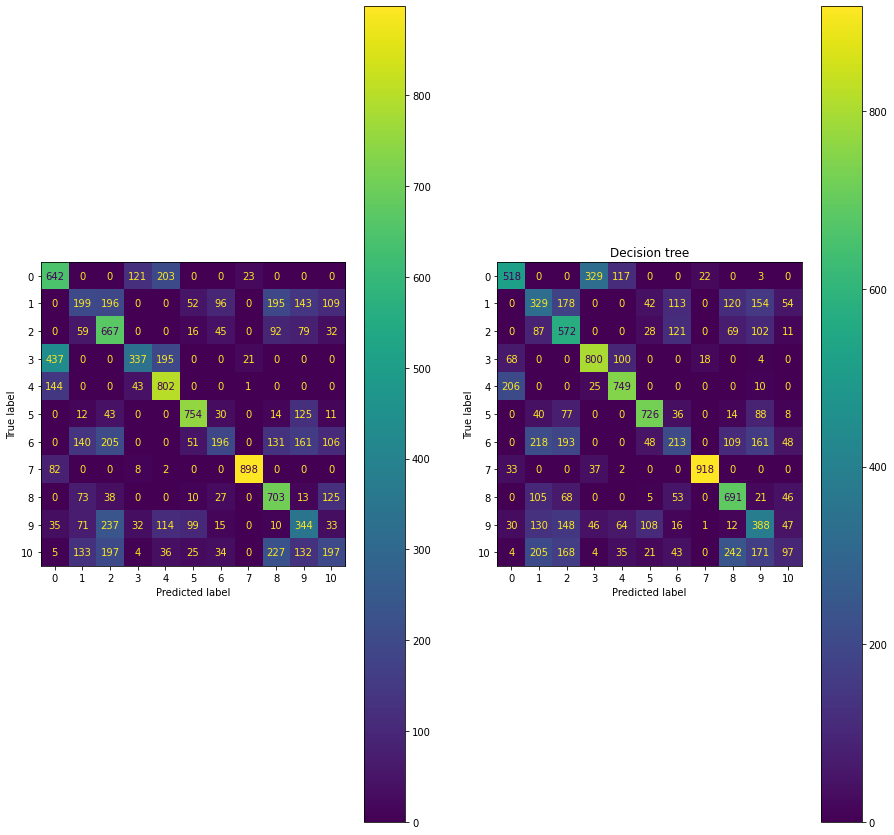

In [48]:
classification_StratifiedKFold_6_features_scale(nb, dct,X_sm_6, y_sm_6, popularity=None, danceability=None,energy=None, speechiness=None, instrumentalness=None, duration=None)

Lần lặp thứ 1:
Chỉ số tập train:  [    1     3     5 ... 54435 54437 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [    0     2     4 ... 54424 54427 54436]
Độ dài tập test:  10888
Accuracy score NB:  34.707935341660544
Accuracy score Decision tree:  57.87105069801617
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.40      0.15      0.22       990
           1       0.21      0.49      0.29       989
           2       0.29      0.54      0.37       990
           3       0.58      0.51      0.54       990
           4       0.55      0.73      0.63       989
           5       0.26      0.28      0.27       990
           6       0.17      0.00      0.00       990
           7       0.41      0.66      0.51       990
           8       0.32      0.23      0.27       990
           9       0.27      0.13      0.18       990
          10       0.31      0.09      0.13       990

    accuracy                           0.35 

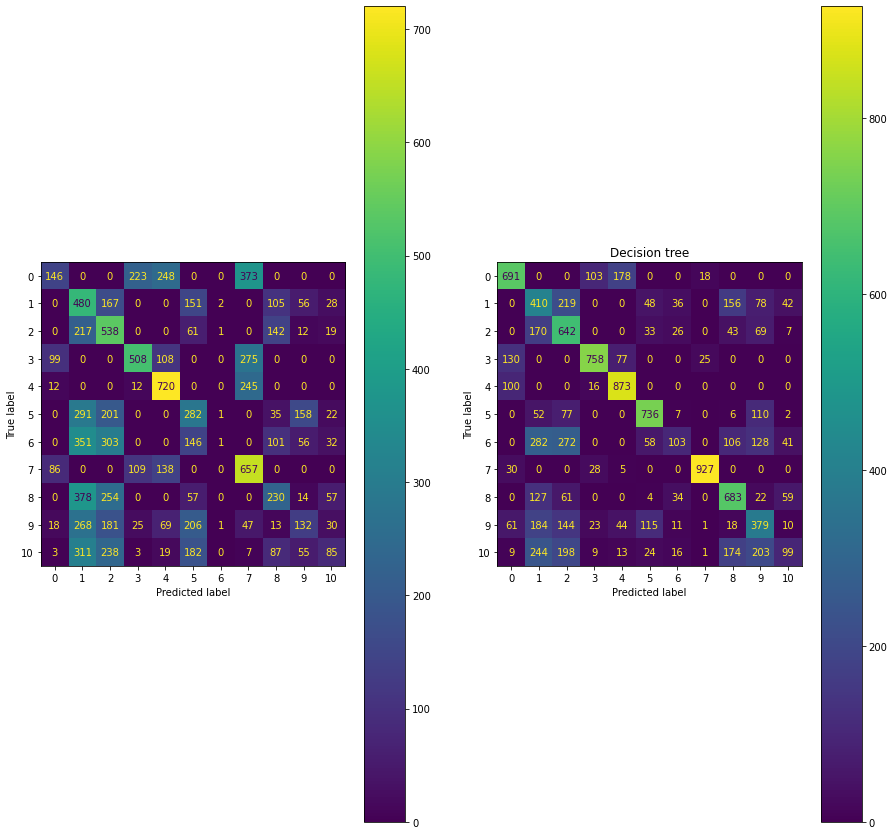

Lần lặp thứ 2:
Chỉ số tập train:  [    0     1     2 ... 54435 54436 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [   12    19    20 ... 54425 54434 54437]
Độ dài tập test:  10888
Accuracy score NB:  34.671197648787654
Accuracy score Decision tree:  58.35782512858193
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.40      0.15      0.21       990
           1       0.21      0.47      0.29       990
           2       0.29      0.57      0.38       989
           3       0.58      0.51      0.54       990
           4       0.55      0.73      0.63       990
           5       0.24      0.29      0.27       990
           6       0.17      0.00      0.00       990
           7       0.42      0.69      0.52       989
           8       0.30      0.22      0.25       990
           9       0.28      0.12      0.17       990
          10       0.29      0.07      0.12       990

    accuracy                           0.35 

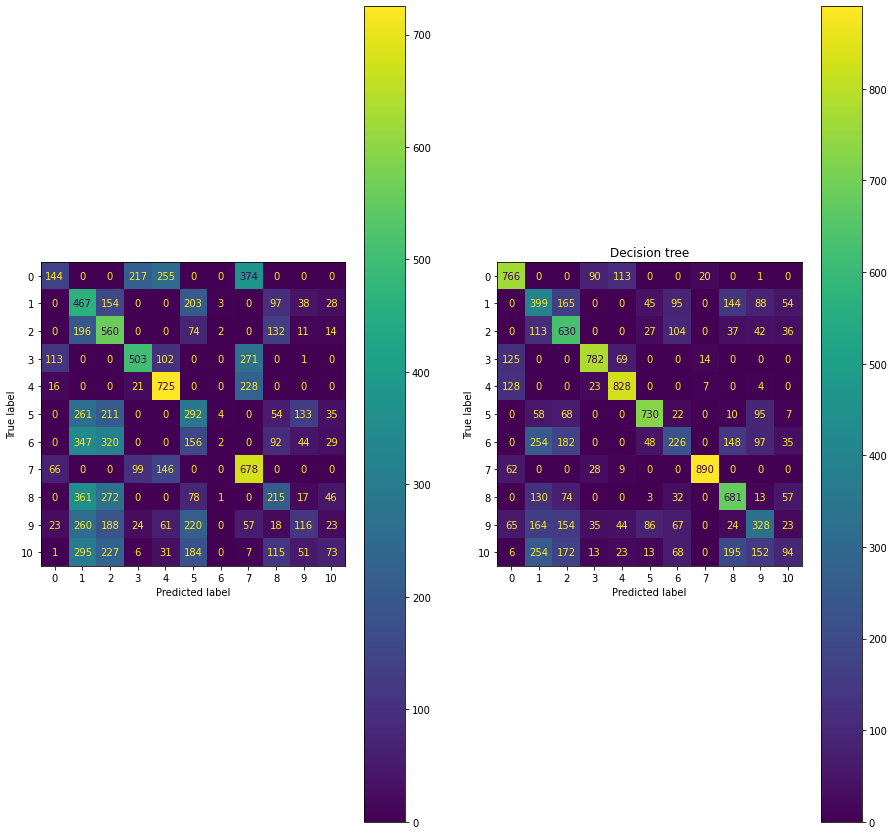

Lần lặp thứ 3:
Chỉ số tập train:  [    0     2     3 ... 54435 54436 54437]
Độ dài tập train:  43551
Chỉ số tập test:  [    1     8    10 ... 54432 54433 54438]
Độ dài tập test:  10888
Accuracy score NB:  34.377296105804554
Accuracy score Decision tree:  58.275165319617926
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.39      0.14      0.21       990
           1       0.20      0.47      0.28       990
           2       0.28      0.54      0.37       990
           3       0.59      0.52      0.56       989
           4       0.56      0.72      0.63       990
           5       0.26      0.32      0.28       990
           6       0.25      0.00      0.01       989
           7       0.41      0.68      0.51       990
           8       0.31      0.21      0.25       990
           9       0.26      0.11      0.15       990
          10       0.33      0.07      0.11       990

    accuracy                           0.34

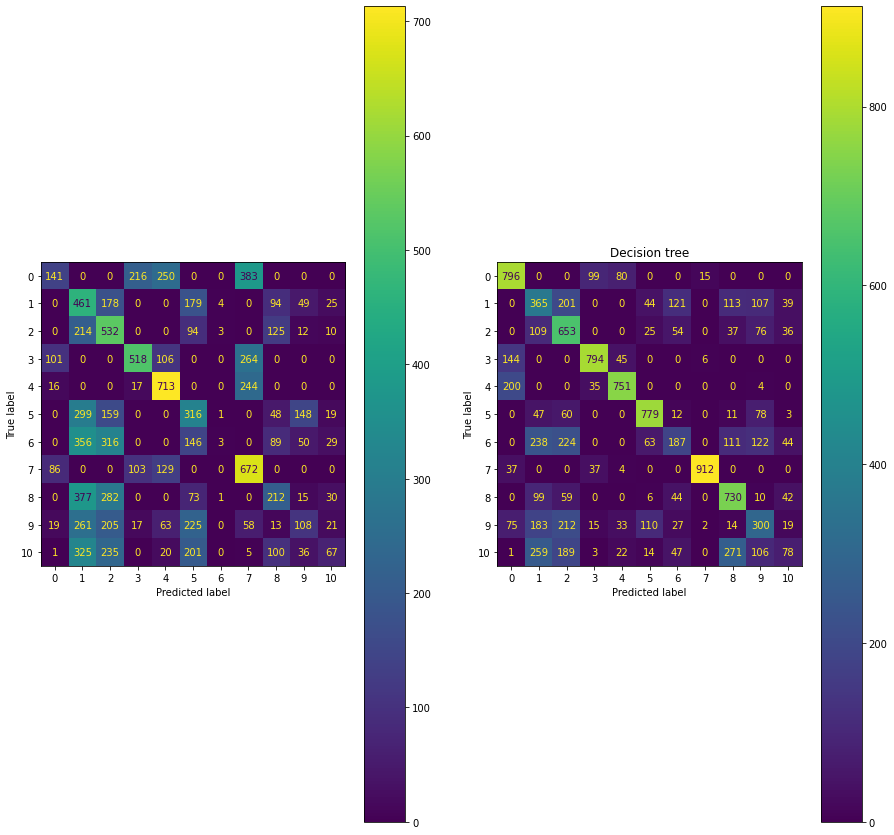

Lần lặp thứ 4:
Chỉ số tập train:  [    0     1     2 ... 54436 54437 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [    9    13    21 ... 54410 54428 54431]
Độ dài tập test:  10888
Accuracy score NB:  34.21197648787656
Accuracy score Decision tree:  57.82512858192506
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.39      0.16      0.23       990
           1       0.21      0.47      0.29       990
           2       0.29      0.55      0.38       990
           3       0.58      0.53      0.55       990
           4       0.55      0.70      0.62       990
           5       0.24      0.31      0.27       990
           6       0.24      0.00      0.01       990
           7       0.39      0.63      0.48       990
           8       0.34      0.23      0.28       990
           9       0.25      0.11      0.15       989
          10       0.27      0.08      0.12       989

    accuracy                           0.34  

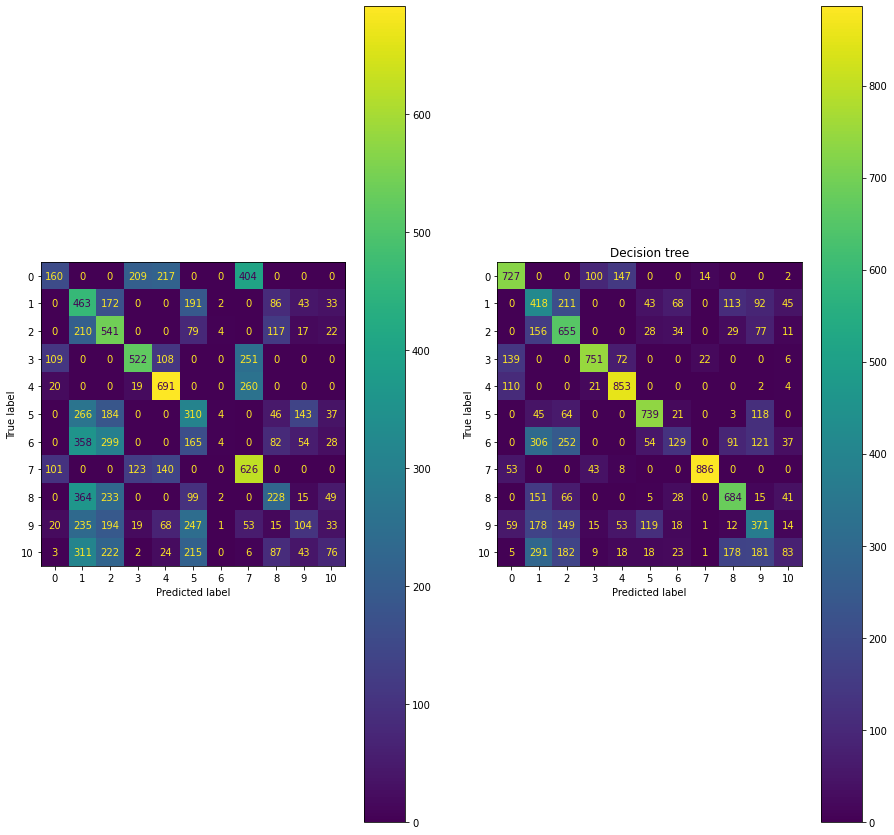

Lần lặp thứ 5:
Chỉ số tập train:  [    0     1     2 ... 54436 54437 54438]
Độ dài tập train:  43552
Chỉ số tập test:  [    3     5     6 ... 54421 54426 54435]
Độ dài tập test:  10887
Accuracy score NB:  34.224304216037474
Accuracy score Decision tree:  57.46302930100119
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.43      0.15      0.22       989
           1       0.20      0.45      0.28       990
           2       0.29      0.52      0.37       990
           3       0.60      0.52      0.56       990
           4       0.54      0.71      0.62       990
           5       0.24      0.32      0.27       989
           6       0.30      0.01      0.01       990
           7       0.40      0.67      0.50       990
           8       0.30      0.23      0.26       989
           9       0.27      0.10      0.15       990
          10       0.29      0.08      0.12       990

    accuracy                           0.34 

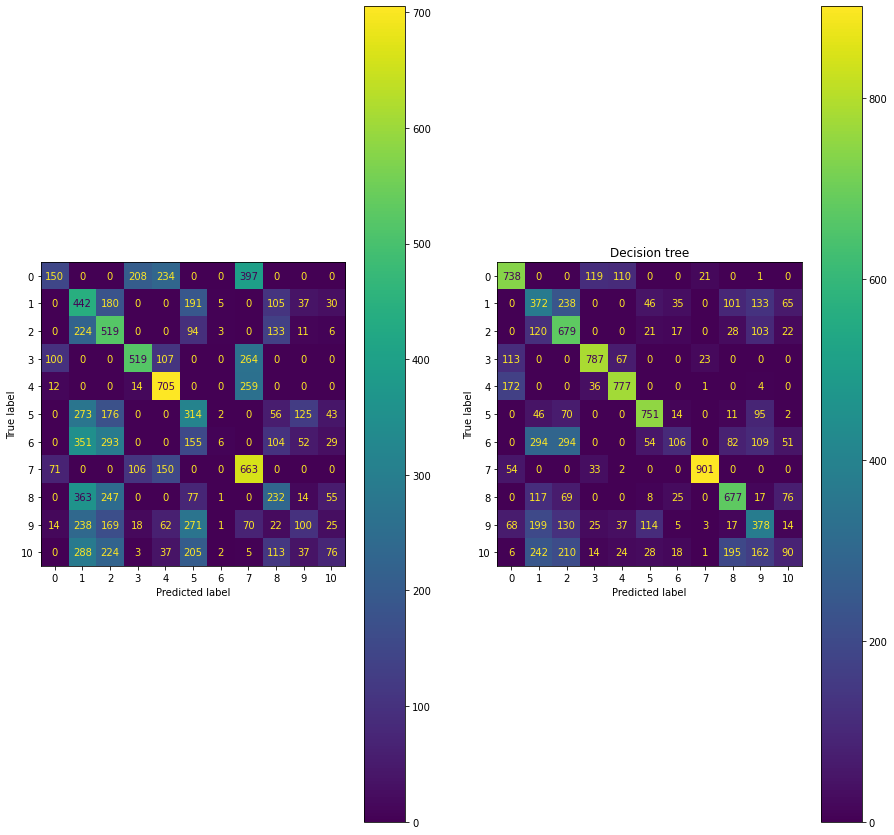

In [49]:
classification_StratifiedKFold_8_features(nb,dct,X_sm_8,y_sm_8, popularity=None, danceability=None,energy=None, speechiness=None, instrumentalness=None, valence=None, tempo=None,duration=None)

Lần lặp thứ 1:
Chỉ số tập train:  [    1     3     5 ... 54435 54437 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [    0     2     4 ... 54424 54427 54436]
Độ dài tập test:  10888
Accuracy score NB:  55.41880969875091
Accuracy score Decision tree:  57.687362233651726
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       990
           1       0.31      0.22      0.25       989
           2       0.45      0.66      0.54       990
           3       0.75      0.53      0.62       990
           4       0.63      0.82      0.71       989
           5       0.72      0.73      0.73       990
           6       0.37      0.19      0.25       990
           7       0.95      0.93      0.94       990
           8       0.56      0.72      0.63       990
           9       0.33      0.37      0.35       990
          10       0.32      0.22      0.26       990

    accuracy                           0.55 

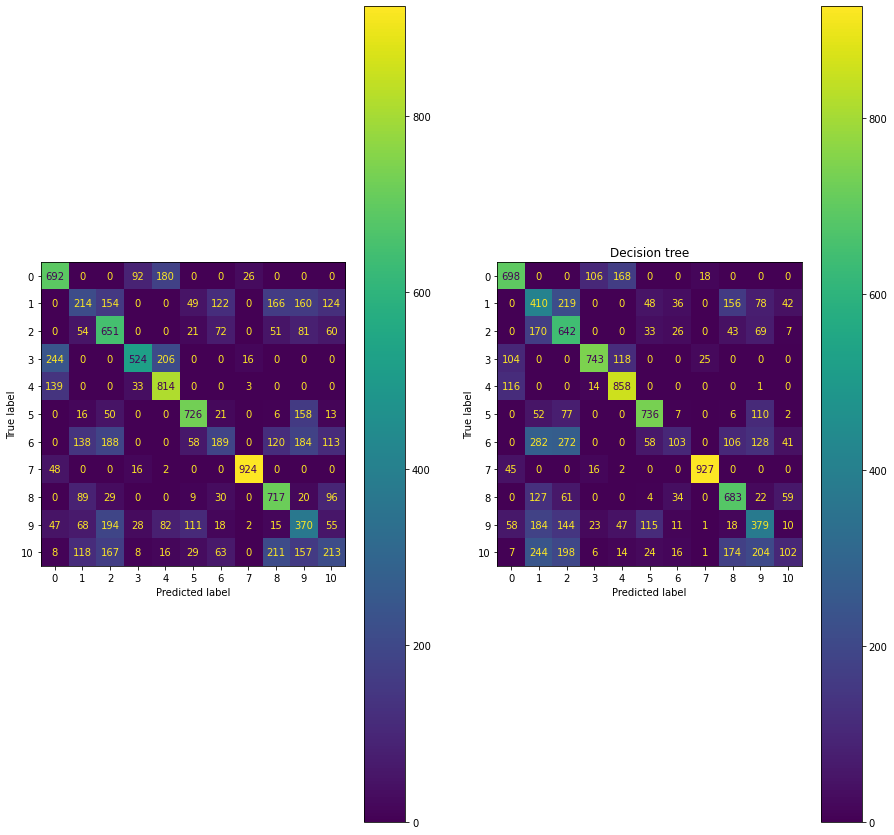

Lần lặp thứ 2:
Chỉ số tập train:  [    0     1     2 ... 54435 54436 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [   12    19    20 ... 54425 54434 54437]
Độ dài tập test:  10888
Accuracy score NB:  55.7494489346069
Accuracy score Decision tree:  57.86186627479795
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       990
           1       0.32      0.26      0.29       990
           2       0.48      0.69      0.56       989
           3       0.74      0.54      0.62       990
           4       0.61      0.79      0.69       990
           5       0.74      0.73      0.74       990
           6       0.42      0.23      0.30       990
           7       0.93      0.92      0.92       989
           8       0.54      0.72      0.62       990
           9       0.34      0.38      0.36       990
          10       0.30      0.17      0.21       990

    accuracy                           0.56   

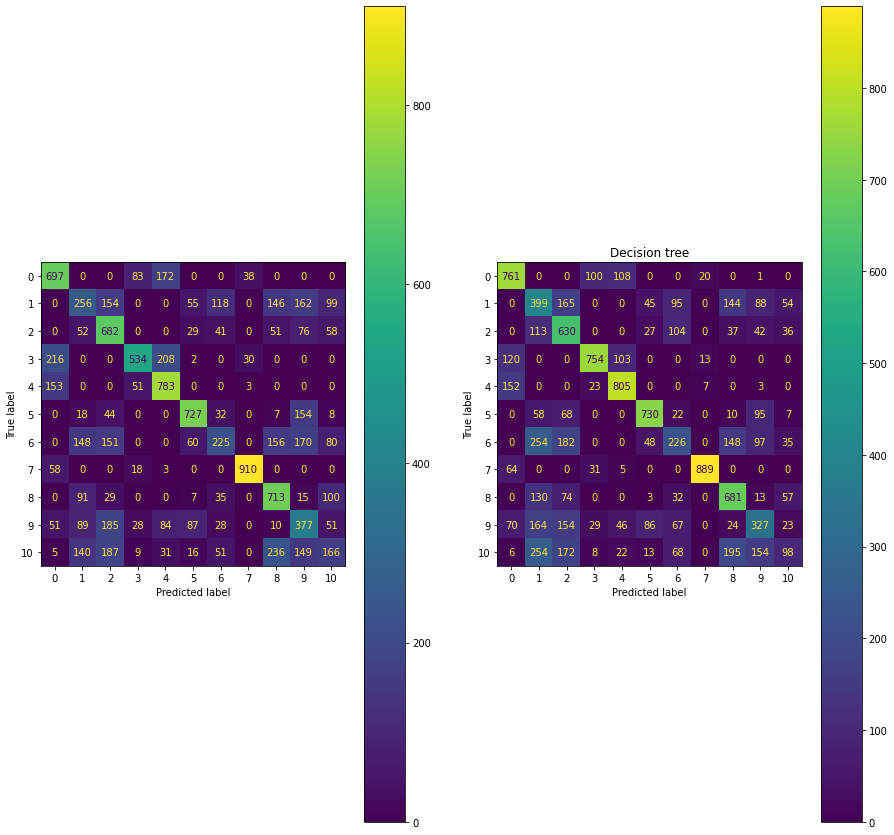

Lần lặp thứ 3:
Chỉ số tập train:  [    0     2     3 ... 54435 54436 54437]
Độ dài tập train:  43551
Chỉ số tập test:  [    1     8    10 ... 54432 54433 54438]
Độ dài tập test:  10888
Accuracy score NB:  56.09845701689934
Accuracy score Decision tree:  57.73328434974284
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.59      0.71      0.64       990
           1       0.31      0.23      0.27       990
           2       0.46      0.67      0.54       990
           3       0.78      0.55      0.64       989
           4       0.62      0.81      0.70       990
           5       0.73      0.77      0.75       990
           6       0.37      0.21      0.26       989
           7       0.95      0.92      0.93       990
           8       0.56      0.76      0.64       990
           9       0.32      0.34      0.33       990
          10       0.35      0.20      0.26       990

    accuracy                           0.56  

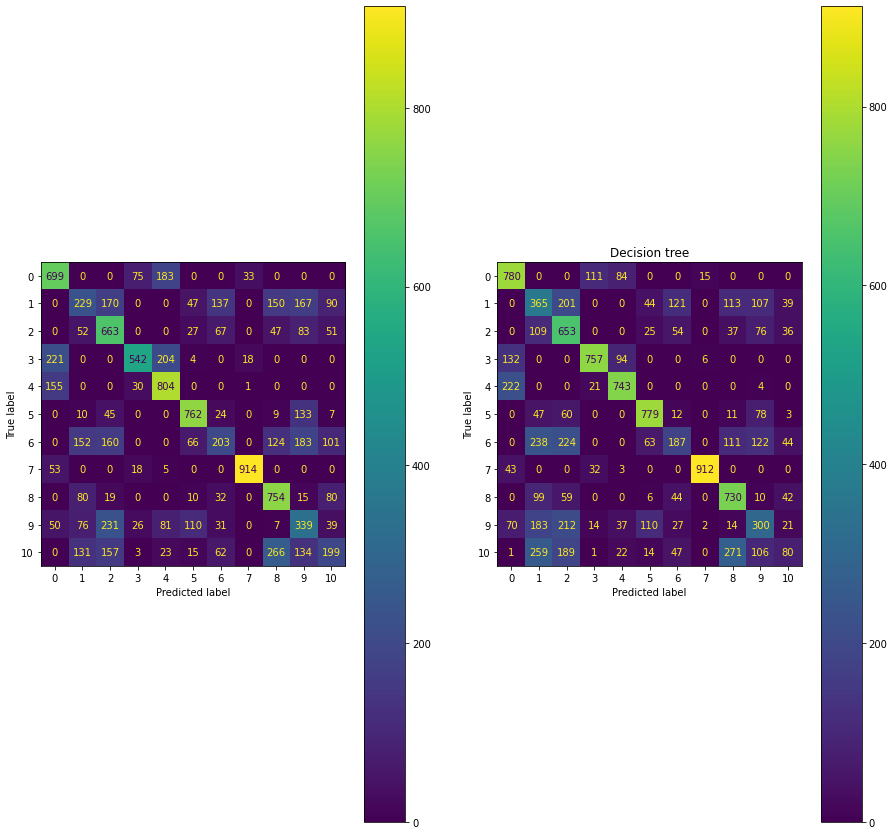

Lần lặp thứ 4:
Chỉ số tập train:  [    0     1     2 ... 54436 54437 54438]
Độ dài tập train:  43551
Chỉ số tập test:  [    9    13    21 ... 54410 54428 54431]
Độ dài tập test:  10888
Accuracy score NB:  55.7494489346069
Accuracy score Decision tree:  57.43019838354151
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.59      0.72      0.65       990
           1       0.31      0.22      0.26       990
           2       0.46      0.68      0.55       990
           3       0.75      0.54      0.63       990
           4       0.63      0.83      0.72       990
           5       0.72      0.74      0.73       990
           6       0.39      0.21      0.27       990
           7       0.96      0.90      0.93       990
           8       0.56      0.73      0.63       990
           9       0.32      0.37      0.34       989
          10       0.33      0.20      0.25       989

    accuracy                           0.56   

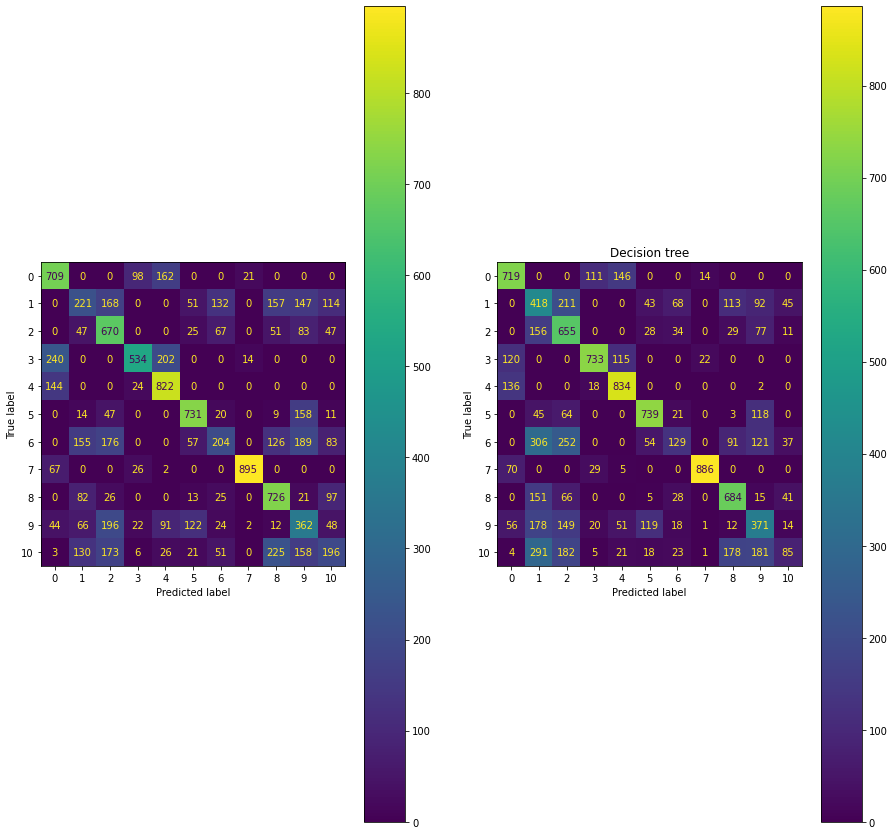

Lần lặp thứ 5:
Chỉ số tập train:  [    0     1     2 ... 54436 54437 54438]
Độ dài tập train:  43552
Chỉ số tập test:  [    3     5     6 ... 54421 54426 54435]
Độ dài tập test:  10887
Accuracy score NB:  56.18627721135299
Accuracy score Decision tree:  56.994580692569116
Dự đoán cho từng phân lớp (NB): 
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       989
           1       0.28      0.21      0.24       990
           2       0.47      0.67      0.55       990
           3       0.78      0.54      0.64       990
           4       0.61      0.81      0.70       990
           5       0.73      0.75      0.74       989
           6       0.43      0.23      0.30       990
           7       0.95      0.93      0.94       990
           8       0.55      0.73      0.63       989
           9       0.33      0.37      0.35       990
          10       0.33      0.20      0.25       990

    accuracy                           0.56 

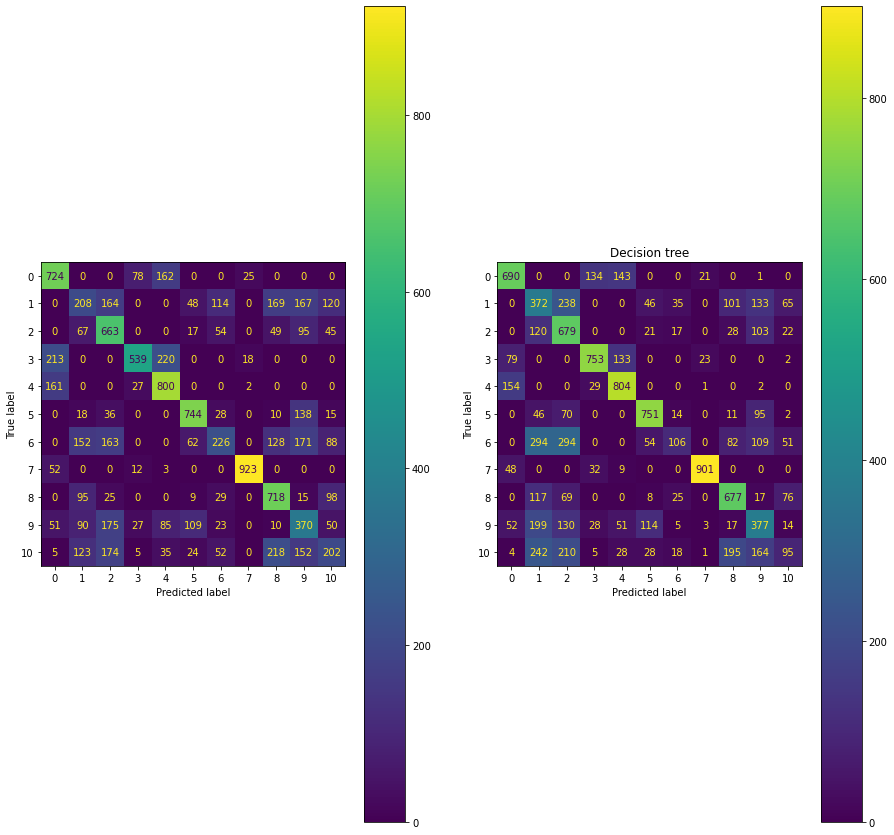

In [50]:
classification_StratifiedKFold_8_features_scale(nb,dct,X_sm_8,y_sm_8, popularity=None, danceability=None,energy=None, speechiness=None, instrumentalness=None, valence=None, tempo=None,duration=None)

## **Sử dụng nghi thức đánh giá Hold out**


*   Độ chính xác khi sử dụng nghi thức hold out cho huấn luyện mô hình bằng Naive Bayes vẫn tương đương với khi sử dụng StratifiedKFold
*   Sử dụng thư viện preprocessing với hàm chuẩn hóa dữ liệu là StandardScaler => cho ra độ chính xác đối với mô hình huấn luyện bằng Naive Bayes tương đối nhỉnh hơn so với không tiền xử lý








### **Xây dựng hàm phân loại sử dụng nghi thức đánh giá Hold out**

In [51]:
#Hàm chưa sử dụng chuẩn hóa StandardScaler
def classification(classifier, X, y, random_state=0):
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=random_state)
  print("Tập train: ", len(X_train))
  print("Tập test: ", len(X_test))
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  print("accuracy score: ", accuracy_score(y_test, y_pred)*100)
  cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
  print(cm)
  print(classification_report(y_test, y_pred))
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
  disp.plot(ax=ax)
  plt.show()

In [52]:
#Hàm có sử dụng chuẩn hóa StandardScaler
def classification_scale(classifier, X, y, random_state=0):
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=random_state)
  print("Tập train: ", len(X_train))
  print("Tập test: ", len(X_test))
  scaler = StandardScaler()
  X_train_scale = scaler.fit_transform(X_train)
  X_test_scale = scaler.transform(X_test)
  classifier.fit(X_train_scale, y_train)
  y_pred = classifier.predict(X_test_scale)
  print("accuracy score: ", accuracy_score(y_test, y_pred)*100)
  cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
  print(cm)
  print(classification_report(y_test, y_pred))
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
  disp.plot(ax=ax)
  plt.show()

### **Sử dụng hàm**

In [53]:
#Tìm giá trị random_state cho mô hình
#for i in range(0, 10):
  # print("Random state = ",i)
  # classification(nb, X_new, y_new, random_state=i)

**Cho dữ liệu ban đầu (chưa cân bằng)**

Tập train:  12597
Tập test:  5399
accuracy score:  35.06204852750509
[[ 108    0    0   28   21    0    0   12    0    0    0]
 [   0    1    4    0    0    0   21    0    0   20  377]
 [   0    0   24    0    0    0   72    0    2    8  289]
 [  50    0    0   65   14    0    0    9    0    2    0]
 [  36    0    0    1   64    0    0   13    0    0    0]
 [   0    0    3    0    0    0   21    0    0   74  310]
 [   0    1   37    0    0    0   79    0    0   29  628]
 [  23    0    0    2    1    0    0  131    0    0    0]
 [   0    0    0    0    0    0    9    0    9    5  508]
 [  66    0    1   13   44    0   43    1    0  109  472]
 [  14    0   14    2   39    0   83    0    4   80 1303]]
              precision    recall  f1-score   support

           0       0.36      0.64      0.46       169
           1       0.50      0.00      0.00       423
           2       0.29      0.06      0.10       395
           3       0.59      0.46      0.52       140
           4       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


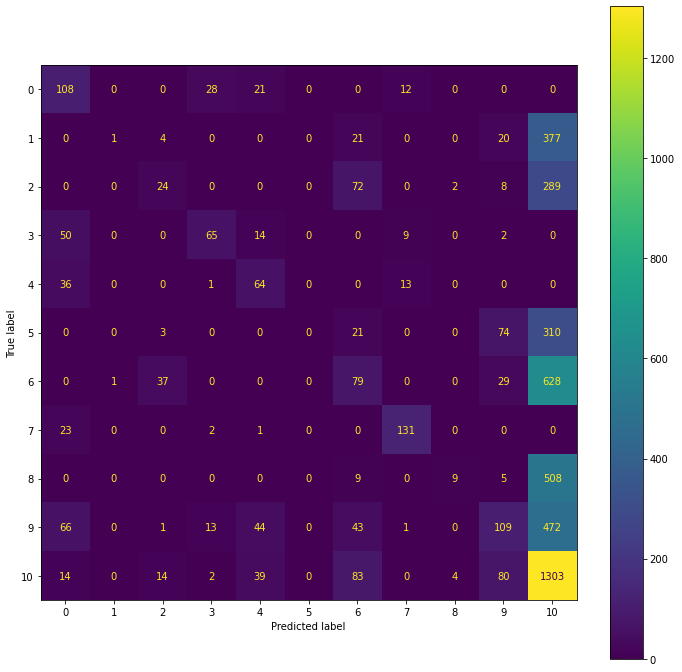

In [54]:
classification(nb, X_new, y_new, random_state=3)

Tập train:  12597
Tập test:  5399
accuracy score:  33.19133172809779
[[  34    0    0   32   22    0    0   81    0    0    0]
 [   0    0    0    0    0    0    9    0    0   14  400]
 [   0    0    0    0    0    0   43    0    0    8  344]
 [  32    0    0   54   15    0    0   37    0    2    0]
 [   1    0    0    1   73    0    0   39    0    0    0]
 [   0    0    0    0    0    0   18    0    0   51  339]
 [   0    0    0    0    0    0   59    0    0   18  697]
 [  17    0    0    6   13    0    0  121    0    0    0]
 [   0    0    0    0    0    0   15    0    0    3  513]
 [  14    0    0   12   41    0   51   57    0   87  487]
 [   0    0    0    2   37    0   73   16    0   47 1364]]
              precision    recall  f1-score   support

           0       0.35      0.20      0.25       169
           1       0.00      0.00      0.00       423
           2       0.00      0.00      0.00       395
           3       0.50      0.39      0.44       140
           4       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


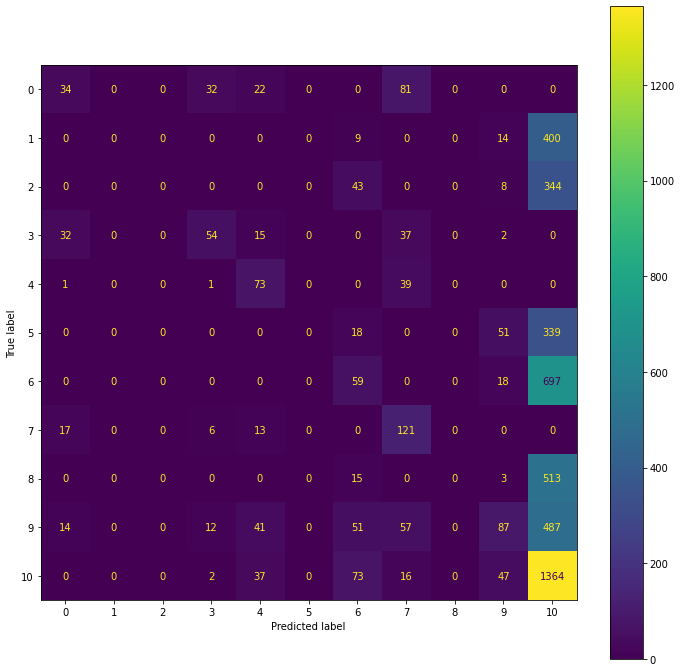

In [55]:
classification(nb, X_6, y,random_state=3)

Tập train:  12597
Tập test:  5399
accuracy score:  44.76754954621226
[[ 121    0    0   17   22    0    0    8    0    1    0]
 [   0    0   16    0    0   20   59    0   37   53  238]
 [   0    0   89    0    0    7   30    0   17   68  184]
 [  68    0    0   40   24    2    0    5    0    1    0]
 [  27    0    0    4   83    0    0    0    0    0    0]
 [   0    0    2    0    0  277    8    0    5   84   32]
 [   0    0   42    0    0   42  153    0   55  140  342]
 [  16    0    0    1    0    0    0  140    0    0    0]
 [   0    0    1    0    0    5   17    0  241    4  263]
 [  43    0   51   19   61   53   22    1    1  259  239]
 [   7    0   63    6   42   25   64    0  169  149 1014]]
              precision    recall  f1-score   support

           0       0.43      0.72      0.54       169
           1       0.00      0.00      0.00       423
           2       0.34      0.23      0.27       395
           3       0.46      0.29      0.35       140
           4       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


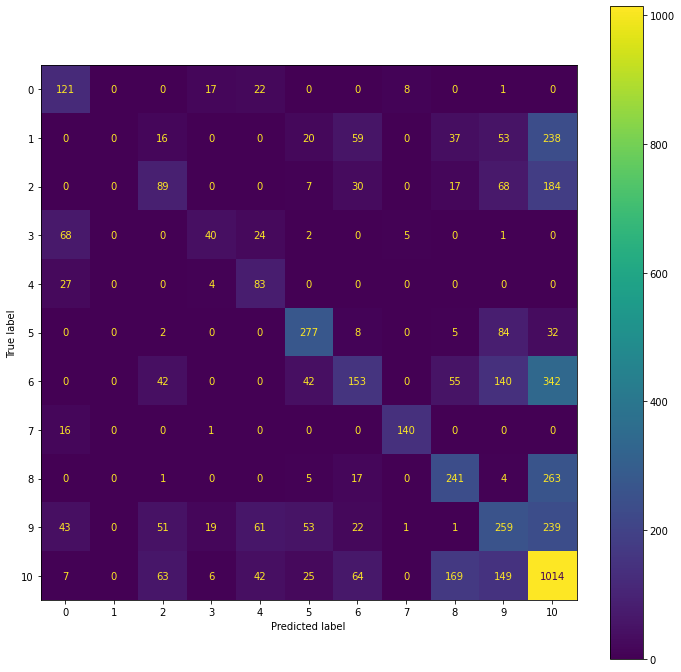

In [56]:
classification_scale(nb, X_6, y,random_state=3)

Tập train:  12597
Tập test:  5399
accuracy score:  33.4135951102056
[[  61    0    0   25   21    0    0   62    0    0    0]
 [   0    0    0    0    0    0   18    0    0   15  390]
 [   0    0    2    0    0    0   54    0    0    5  334]
 [  29    0    0   58   13    0    0   38    0    2    0]
 [  14    0    0    1   68    0    0   31    0    0    0]
 [   0    0    2    0    0    0   20    0    0   61  325]
 [   0    0    6    0    0    0   78    0    0   22  668]
 [  34    0    0    6   10    0    0  107    0    0    0]
 [   0    0    0    0    0    0   20    0    0    4  507]
 [  34    0    0   13   40    0   69   37    0   97  459]
 [   5    0    3    2   36    0   87   12    0   61 1333]]
              precision    recall  f1-score   support

           0       0.34      0.36      0.35       169
           1       0.00      0.00      0.00       423
           2       0.15      0.01      0.01       395
           3       0.55      0.41      0.47       140
           4       0.3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


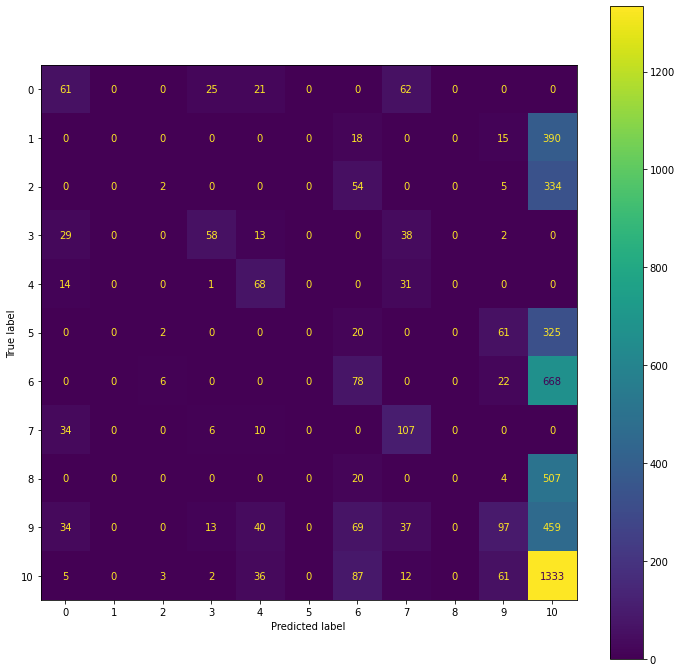

In [57]:
classification(nb, X_8, y, random_state=3)

Tập train:  12597
Tập test:  5399
accuracy score:  45.50842748657159
[[114   0   0  15  29   0   0  10   0   1   0]
 [  0   0  10   0   0  21  67   0  44  65 216]
 [  0   0  92   0   0   7  28   0  11  69 188]
 [ 43   0   0  64  25   2   0   5   0   1   0]
 [ 23   0   0   4  87   0   0   0   0   0   0]
 [  0   0   3   0   0 275  10   0   2  90  28]
 [  0   0  27   0   0  42 164   0  57 152 332]
 [ 12   0   0   3   0   0   0 142   0   0   0]
 [  0   1   0   0   0   4  18   0 280   5 223]
 [ 51   0  33  16  55  54  27   2   2 282 227]
 [  6   0  48   6  43  27  71   0 203 178 957]]
              precision    recall  f1-score   support

           0       0.46      0.67      0.55       169
           1       0.00      0.00      0.00       423
           2       0.43      0.23      0.30       395
           3       0.59      0.46      0.52       140
           4       0.36      0.76      0.49       114
           5       0.64      0.67      0.65       408
           6       0.43      0.21 

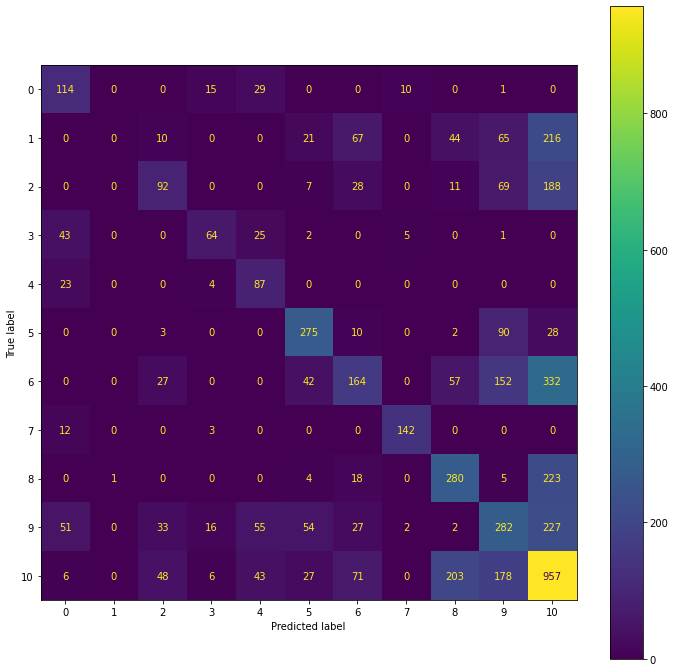

In [58]:
classification_scale(nb, X_8, y, random_state=3)

**Cho dữ liệu đã cân bằng**

Tập train:  38107
Tập test:  16332
accuracy score:  33.345579230957625
[[  36    0    0  418  371    0    0  692    0    0    0]
 [   0  745  259    0    0  221    0    0  160   73   15]
 [   0  409  823    0    0   43    0    0  157   19   19]
 [  50    0    0  818  179    0    0  397    0    0    0]
 [   3    0    0   40 1072    0    0  368    0    0    0]
 [   0  465  307    0    0  385    0    0  101  201   33]
 [   0  579  464    0    0  169    0    0  128   72   35]
 [  13    0    0  222  280    0    0 1007    0    0    0]
 [   0  590  396    0    0   86    0    0  317   19   67]
 [   6  457  259   48  102  336    0   95   26  160   26]
 [   1  585  351    4   31  239    0   13  127   60   83]]
              precision    recall  f1-score   support

           0       0.33      0.02      0.04      1517
           1       0.19      0.51      0.28      1473
           2       0.29      0.56      0.38      1470
           3       0.53      0.57      0.55      1444
           4       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


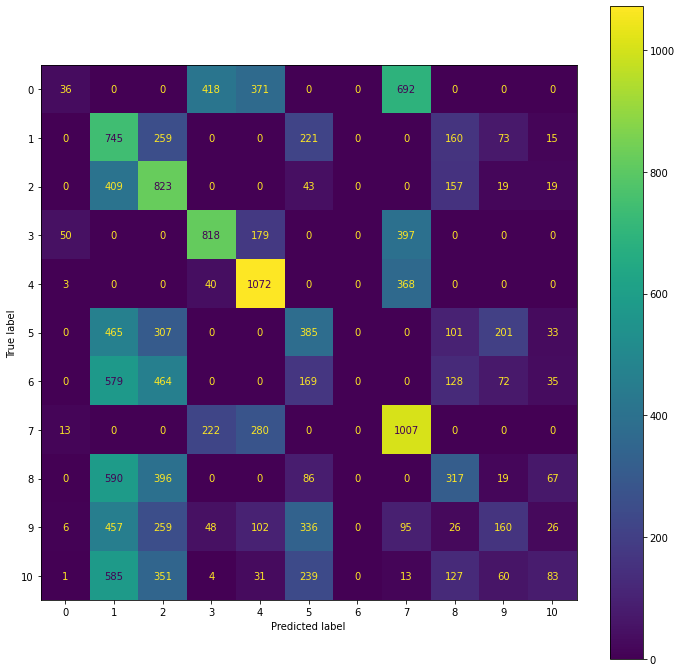

In [59]:
classification(nb, X_sm_6, y_sm_6, random_state=3)

Tập train:  38107
Tập test:  16332
accuracy score:  52.84717119764879
[[ 980    0    0  184  324    0    0   29    0    0    0]
 [   0  334  244    0    0   74  192    0  276  222  131]
 [   0  105  936    0    0   25   83    0  138  132   51]
 [ 625    0    0  515  273    1    0   30    0    0    0]
 [ 198    0    0   55 1230    0    0    0    0    0    0]
 [   0   24   68    0    0 1112   46    0   13  216   13]
 [   0  247  308    0    0   82  269    0  198  219  124]
 [  95    0    0   15    5    0    0 1407    0    0    0]
 [   0  121   70    0    0   13   33    0 1070   21  147]
 [  51  127  349   61  136  162   24    1   13  533   58]
 [   5  227  293    7   37   32   64    0  385  199  245]]
              precision    recall  f1-score   support

           0       0.50      0.65      0.56      1517
           1       0.28      0.23      0.25      1473
           2       0.41      0.64      0.50      1470
           3       0.62      0.36      0.45      1444
           4       0

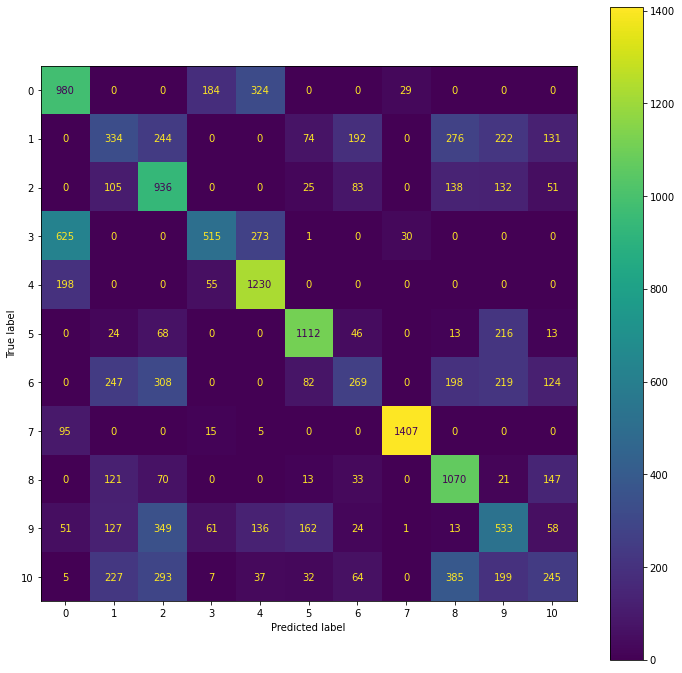

In [60]:
classification_scale(nb, X_sm_6, y_sm_6, random_state=3)

Tập train:  38107
Tập test:  16332
accuracy score:  34.96203771736468
[[ 217    0    0  341  374    0    0  585    0    0    0]
 [   0  701  252    0    0  268   10    0  136   72   34]
 [   0  316  796    0    0  145   10    0  171   19   13]
 [ 145    0    0  790  134    0    0  375    0    0    0]
 [  21    0    0   23 1069    0    0  370    0    0    0]
 [   0  407  271    0    0  479    3    0   84  200   48]
 [   0  489  465    0    0  239    8    0  135   72   39]
 [ 107    0    0  152  217    0    0 1046    0    0    0]
 [   0  556  381    0    0  125    4    0  316   21   72]
 [  22  407  249   35  105  380    1   80   23  173   40]
 [   2  495  344    4   32  291    2   11  142   56  115]]
              precision    recall  f1-score   support

           0       0.42      0.14      0.21      1517
           1       0.21      0.48      0.29      1473
           2       0.29      0.54      0.38      1470
           3       0.59      0.55      0.57      1444
           4       0

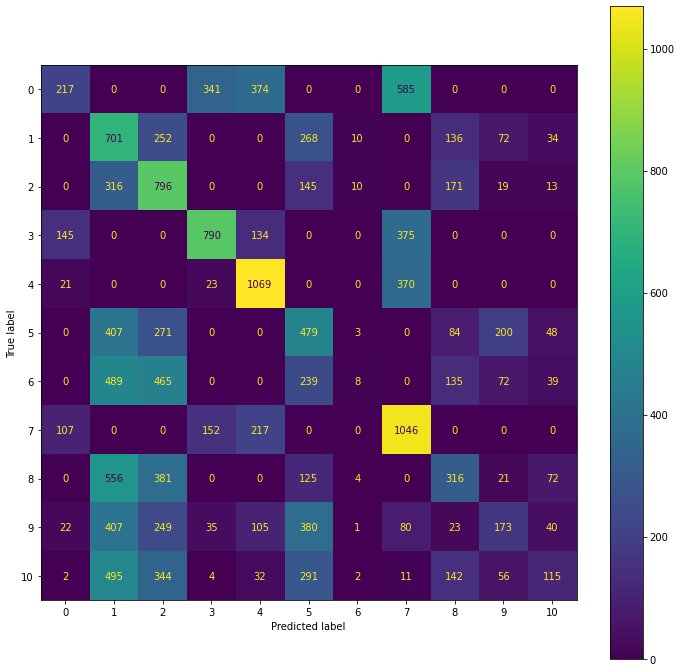

In [61]:
classification(nb, X_sm_8, y_sm_8, random_state=3)

Tập train:  38107
Tập test:  16332
accuracy score:  56.0555963752143
[[1082    0    0  139  258    0    0   38    0    0    0]
 [   0  351  230    0    0   71  192    0  234  246  149]
 [   0   82  993    0    0   35   87    0   75  132   66]
 [ 319    0    0  806  290    3    0   26    0    0    0]
 [ 235    0    0   55 1187    0    0    6    0    0    0]
 [   0   17   58    0    0 1110   39    0   17  232   19]
 [   0  238  265    0    0   82  282    0  210  235  135]
 [  91    0    0   25    1    0    0 1405    0    0    0]
 [   0  150   33    0    0   14   42    0 1082   17  137]
 [  75  128  270   36  125  170   37    4   23  584   63]
 [   7  225  248    5   37   28   90    0  359  222  273]]
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      1517
           1       0.29      0.24      0.26      1473
           2       0.47      0.68      0.56      1470
           3       0.76      0.56      0.64      1444
           4       0.

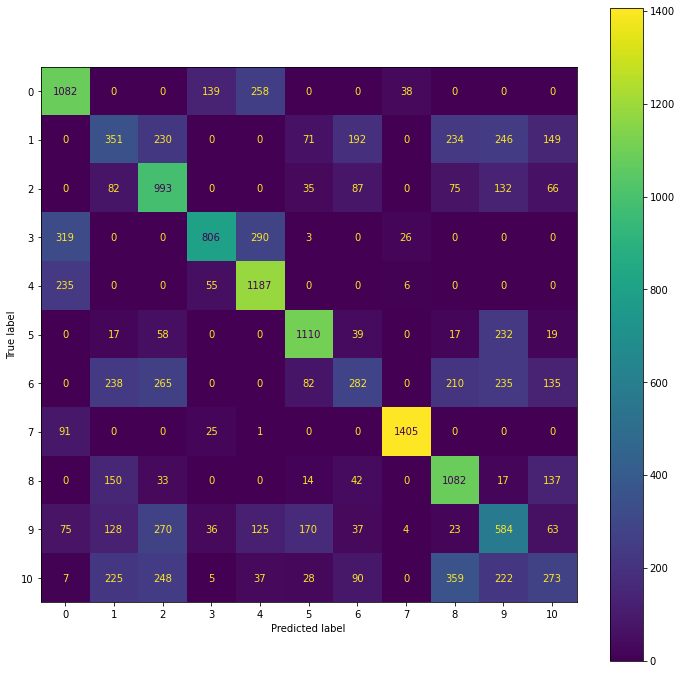

In [62]:
classification_scale(nb, X_sm_8, y_sm_8, random_state=3)